> **Note:** This notebook has been superseded by the comprehensive SGR tutorial series
> in `examples/sgr/`. See `examples/sgr/README.md` for the full 6-notebook set covering
> all rheological protocols with real data and Bayesian inference.

# Soft Glassy Rheology (SGR) Models

This notebook demonstrates SGR models for soft glassy materials (foams, emulsions, pastes, colloidal suspensions) where thermal noise temperature controls phase transitions from glass to power-law fluid to Newtonian liquid.

## What is This?

Soft Glassy Rheology (Sollich 1997, 1998) describes materials as **mesoscopic elements** trapped in energy wells, with dynamics governed by:
- **Noise temperature x**: Effective temperature (normalized by trap depth) controlling thermally-activated hopping
- **Phase diagram**:
  - **x < 1**: Glass (non-ergodic, yield stress, aging)
  - **1 < x < 2**: Power-law fluid (G' ~ G'' ~ ω^(x-1), shear-thinning)
  - **x ≥ 2**: Newtonian liquid (G'' > G', viscous flow)

RheoJAX implements two SGR variants:
- **SGRConventional**: Original Sollich model with soft well escape (analytical SAOS)
- **SGRGeneric**: GENERIC framework version (Füreder & Ilg 2013) with thermodynamic consistency

## Physical Motivation

Soft glassy materials exhibit **universal** features that simple viscoelastic models miss:
- **Aging**: G(t, t_w) depends on waiting time t_w since quench (x < 1)
- **Yield stress**: σ_y ~ x for foams and pastes
- **Power-law rheology**: G' ~ G'' ~ ω^Δ with Δ = x-1 over decades in ω
- **Shear-thinning**: η(γ̇) ~ γ̇^(-β) with β ≈ 1-x

**Examples**:
- **Mayonnaise** (x ≈ 0.7): Glassy, yields at σ_y ≈ 50 Pa, ages over minutes
- **Foam** (x ≈ 1.5): Power-law fluid, G' ~ G'' ~ ω^0.5, no yield stress
- **Microgel suspension** (x ≈ 0.3): Deep glass, extreme aging, logarithmic creep

**Key insight**: The **single parameter x** controls the material's position in the phase diagram, unifying seemingly disparate behaviors.

## Prerequisites

- **Oscillatory rheology**: Understand G'(ω), G''(ω) from SAOS measurements
- **Relaxation modulus**: Familiarity with G(t) from step-strain experiments
- **Glassy dynamics**: Basic concepts of jamming, caging, and ergodicity breaking
- **Statistical mechanics**: Helpful but not required—SGR is phenomenological

## Handbook References

- **SGR models overview**: [docs/source/models/sgr/index.rst](../../docs/source/models/sgr/index.rst)
- **Phase diagram**: Physical interpretation of noise temperature x regimes
- **SRFS transform**: Strain-Rate Frequency Superposition for flow curve analysis
- **Shear banding**: Detection algorithms for heterogeneous flow

**Estimated Time:** 50-60 minutes

> **Handbook:** For theoretical background, see the [Model Documentation](../../docs/source/models/index.rst).

### Learning Objectives
- Understand SGR trap model and noise temperature x
- Classify materials by phase regime (glass/power-law/Newtonian)
- Fit SGR models to oscillation and relaxation data
- Compare SGRConventional vs SGRGeneric formulations

**Estimated Time:** ~50-60 minutes

## Google Colab Setup - Run this cell first!

If running on Google Colab, this cell will install RheoJAX and configure the environment.

In [1]:
# Google Colab Setup - Run this cell first!
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install -q rheojax
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    print("✓ RheoJAX installed successfully!")

## Setup and Imports

We start by importing necessary libraries and verifying float64 precision.

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

# Standard scientific computing imports
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax

# Import SGR models - always use explicit imports
from rheojax.models import SGRConventional, SGRGeneric

# Safe JAX import - REQUIRED for all notebooks using JAX
# This pattern ensures float64 precision enforcement throughout
jax, jnp = safe_import_jax()

# Set reproducible random seed
np.random.seed(42)

# Configure matplotlib for publication-quality plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Suppress warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

print("✓ Setup complete - SGR models loaded with float64 precision")

import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"


✓ Setup complete - SGR models loaded with float64 precision


## 1. Theory: Soft Glassy Rheology

### Physical Background

Soft glassy materials (foams, emulsions, pastes, colloidal suspensions) exhibit complex rheological behavior that classical viscoelastic models cannot capture. The SGR model (Sollich 1998) provides a statistical mechanics framework based on:

**Trap Model:**
- Material consists of mesoscopic elements trapped in energy wells
- Exponential density of states: $\rho(E) \sim \exp(-E)$
- Elements undergo thermally activated hopping between traps

**Noise Temperature x:**

The effective noise temperature $x$ (dimensionless) controls material phase:

- **x < 1:** Glass phase with yield stress (solid-like, aging, non-ergodic)
- **1 < x < 2:** Power-law viscoelastic fluid (SGM regime)
  - $G' \sim G'' \sim \omega^{x-1}$ (characteristic power-law scaling)
- **x ≥ 2:** Newtonian liquid (constant viscosity)

**Model Parameters:**
- `x`: Noise temperature (dimensionless), range (0.5, 3.0)
- `G0`: Modulus scale (Pa), sets absolute magnitude
- `tau0`: Attempt time (s), microscopic relaxation timescale

**Physical Interpretation:**

The noise temperature $x$ quantifies the ratio of thermal fluctuations to the energy scale of structural rearrangements. At $x = 1$, the material undergoes a glass transition from solid-like to fluid-like behavior.

### SGRConventional vs SGRGeneric

RheoJAX provides two SGR implementations:

**1. SGRConventional (Sollich 1998):**
- Standard formulation from original SGR papers
- Supports oscillation, relaxation, creep, steady shear, and LAOS
- Efficient for most applications

**2. SGRGeneric (Fuereder & Ilg 2013):**
- Thermodynamically consistent GENERIC framework
- Explicit entropy production tracking
- Guarantees second law (entropy production ≥ 0)
- Splits dynamics into reversible (Hamiltonian) and irreversible (dissipative) parts
- Same predictions as SGRConventional in linear regime

**When to use each:**
- Use **SGRConventional** for standard rheological fitting
- Use **SGRGeneric** when thermodynamic consistency is critical or for nonequilibrium systems

## 2. Data Generation: Synthetic SGR Material

We generate synthetic frequency-sweep data for a soft glassy material in the power-law regime.

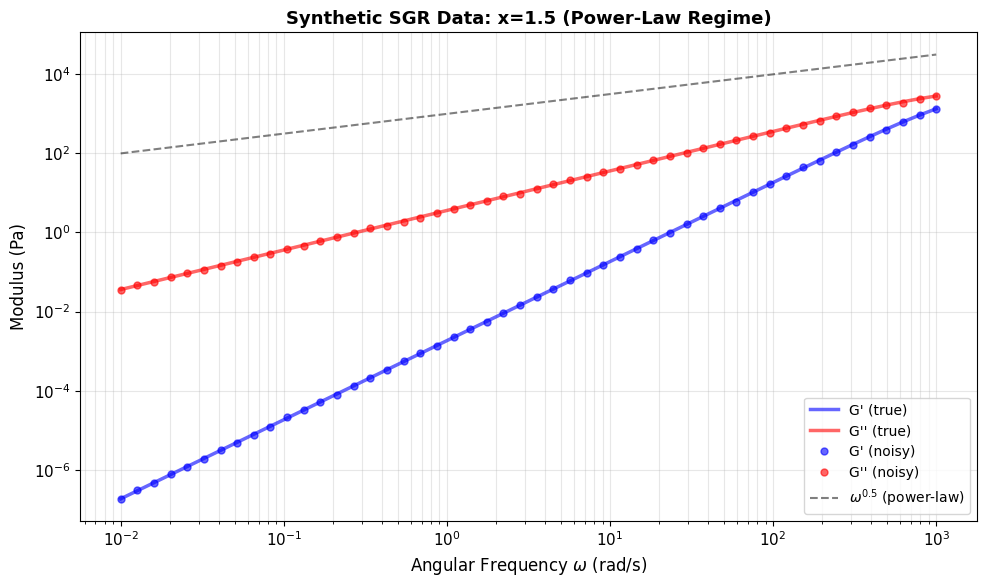

Generated synthetic SGR data:
  True parameters: x=1.5, G0=1.00e+04 Pa, tau0=1.00e-03 s
  Data points: 50
  Frequency range: 1.00e-02 - 1.00e+03 rad/s
  Noise level: 3.0% relative
  Phase regime: Power-law fluid (1 < x < 2)


In [3]:
# True parameters for a soft glassy material (1 < x < 2, power-law fluid regime)
x_true = 1.5  # Power-law fluid (balanced viscoelastic)
G0_true = 1e4  # Pa (typical soft paste/emulsion)
tau0_true = 1e-3  # s (millisecond timescale)

# Generate frequency sweep data
omega = np.logspace(-2, 3, 50)  # rad/s, 5 decades

# Create model with true parameters
model_true = SGRConventional()
model_true.parameters.set_value('x', x_true)
model_true.parameters.set_value('G0', G0_true)
model_true.parameters.set_value('tau0', tau0_true)

# Generate G*(omega) = [G', G'']
model_true._test_mode = 'oscillation'
G_star_true = model_true.predict(omega)

# Add realistic noise (3% relative noise)
noise_level = 0.03
noise = noise_level * G_star_true * np.random.randn(*G_star_true.shape)
G_star_noisy = G_star_true + noise

# Separate G' and G''
G_prime_true = G_star_true[:, 0]
G_double_prime_true = G_star_true[:, 1]
G_prime_noisy = G_star_noisy[:, 0]
G_double_prime_noisy = G_star_noisy[:, 1]

# Visualize synthetic data
fig = plt.figure(figsize=(10, 6))
plt.loglog(omega, G_prime_true, 'b-', linewidth=2.5, alpha=0.6, label="G' (true)")
plt.loglog(omega, G_double_prime_true, 'r-', linewidth=2.5, alpha=0.6, label="G'' (true)")
plt.loglog(omega, G_prime_noisy, 'bo', markersize=5, alpha=0.6, label="G' (noisy)")
plt.loglog(omega, G_double_prime_noisy, 'ro', markersize=5, alpha=0.6, label="G'' (noisy)")

# Add power-law reference
power_law_ref = 1e3 * (omega / 1.0) ** (x_true - 1)
plt.loglog(omega, power_law_ref, 'k--', linewidth=1.5, alpha=0.5, 
           label=rf'$\omega^{{{x_true-1:.1f}}}$ (power-law)')

plt.xlabel(r'Angular Frequency $\omega$ (rad/s)', fontsize=12)
plt.ylabel('Modulus (Pa)', fontsize=12)
plt.title(f'Synthetic SGR Data: x={x_true} (Power-Law Regime)', fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
display(fig)
plt.close(fig)

print(f"Generated synthetic SGR data:")
print(f"  True parameters: x={x_true}, G0={G0_true:.2e} Pa, tau0={tau0_true:.2e} s")
print(f"  Data points: {len(omega)}")
print(f"  Frequency range: {omega.min():.2e} - {omega.max():.2e} rad/s")
print(f"  Noise level: {noise_level*100}% relative")
print(f"  Phase regime: Power-law fluid (1 < x < 2)")

## 3. Model Fitting: SGRConventional

Fit the conventional SGR model to frequency-domain data using NLSQ optimization.

In [4]:
# Create SGRConventional model
sgr_conv = SGRConventional()

# Fit to oscillation data
print("Fitting SGRConventional model...")
sgr_conv.fit(omega, G_star_noisy, test_mode='oscillation')

# Extract fitted parameters
x_fit = sgr_conv.parameters.get_value('x')
G0_fit = sgr_conv.parameters.get_value('G0')
tau0_fit = sgr_conv.parameters.get_value('tau0')

# Predict with fitted model
G_star_pred = sgr_conv.predict(omega)
G_prime_pred = G_star_pred[:, 0]
G_double_prime_pred = G_star_pred[:, 1]

# Calculate R² for G' and G''
def calc_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res / ss_tot

r2_prime = calc_r2(G_prime_noisy, G_prime_pred)
r2_double_prime = calc_r2(G_double_prime_noisy, G_double_prime_pred)

# Get phase regime
phase_regime = sgr_conv.get_phase_regime()

print("\nFitted SGRConventional parameters:")
print(f"  x       = {x_fit:.4f} (true: {x_true:.4f})")
print(f"  G0      = {G0_fit:.2e} Pa (true: {G0_true:.2e} Pa)")
print(f"  tau0    = {tau0_fit:.2e} s (true: {tau0_true:.2e} s)")
print(f"\nFit quality:")
print(f"  R² (G')  = {r2_prime:.6f}")
print(f"  R² (G'') = {r2_double_prime:.6f}")
print(f"\nMaterial classification:")
print(f"  Phase regime: {phase_regime}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Fitting SGRConventional model...


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.013775s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=0.0215 | elapsed=1.014s | final_gradient_norm=2519.0783



Fitted SGRConventional parameters:
  x       = 1.4123 (true: 1.5000)
  G0      = 1.01e+04 Pa (true: 1.00e+04 Pa)
  tau0    = 1.03e-03 s (true: 1.00e-03 s)

Fit quality:
  R² (G')  = 0.999904
  R² (G'') = 0.999488

Material classification:
  Phase regime: power-law


### Visualize Fit Quality

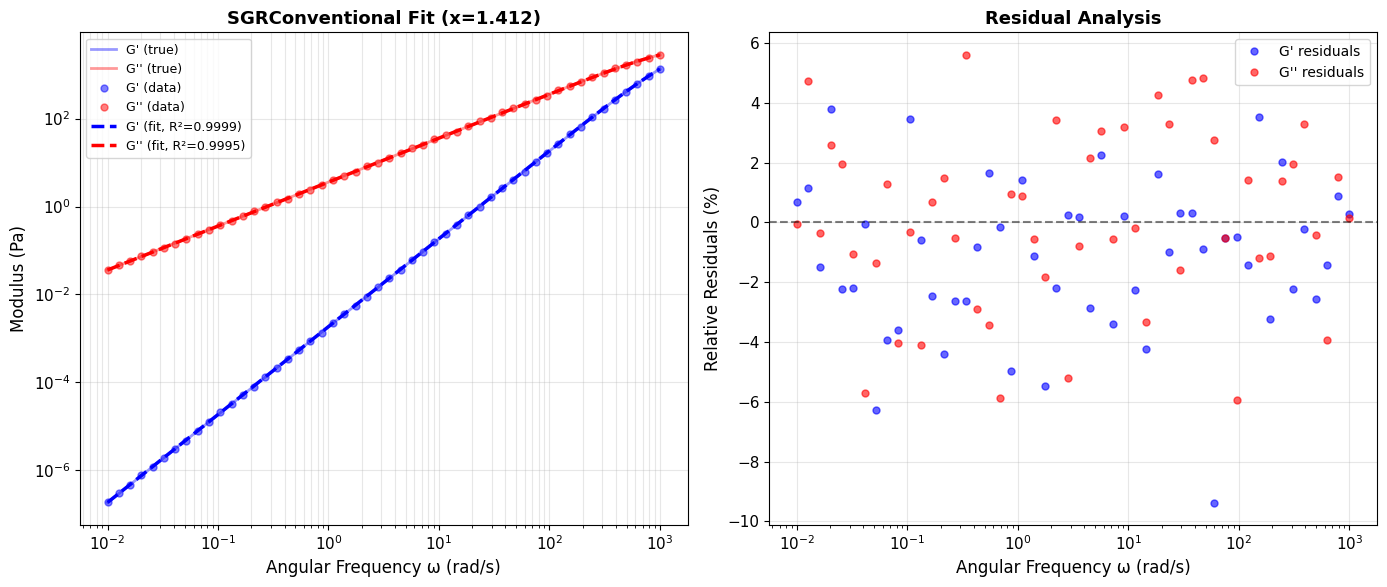

In [5]:
# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Data vs fit
ax1.loglog(omega, G_prime_true, 'b-', linewidth=2, alpha=0.4, label="G' (true)")
ax1.loglog(omega, G_double_prime_true, 'r-', linewidth=2, alpha=0.4, label="G'' (true)")
ax1.loglog(omega, G_prime_noisy, 'bo', markersize=5, alpha=0.5, label="G' (data)")
ax1.loglog(omega, G_double_prime_noisy, 'ro', markersize=5, alpha=0.5, label="G'' (data)")
ax1.loglog(omega, G_prime_pred, 'b--', linewidth=2.5, label=f"G' (fit, R²={r2_prime:.4f})")
ax1.loglog(omega, G_double_prime_pred, 'r--', linewidth=2.5, label=f"G'' (fit, R²={r2_double_prime:.4f})")
ax1.set_xlabel('Angular Frequency ω (rad/s)', fontsize=12)
ax1.set_ylabel('Modulus (Pa)', fontsize=12)
ax1.set_title(f'SGRConventional Fit (x={x_fit:.3f})', fontsize=13, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3, which='both')

# Right: Residuals
residuals_prime = (G_prime_noisy - G_prime_pred) / G_prime_noisy * 100
residuals_double_prime = (G_double_prime_noisy - G_double_prime_pred) / G_double_prime_noisy * 100
ax2.semilogx(omega, residuals_prime, 'bo', markersize=5, alpha=0.6, label="G' residuals")
ax2.semilogx(omega, residuals_double_prime, 'ro', markersize=5, alpha=0.6, label="G'' residuals")
ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel('Angular Frequency ω (rad/s)', fontsize=12)
ax2.set_ylabel('Relative Residuals (%)', fontsize=12)
ax2.set_title('Residual Analysis', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. Exploring Material Phase Regimes

Demonstrate how noise temperature x controls the phase transition.

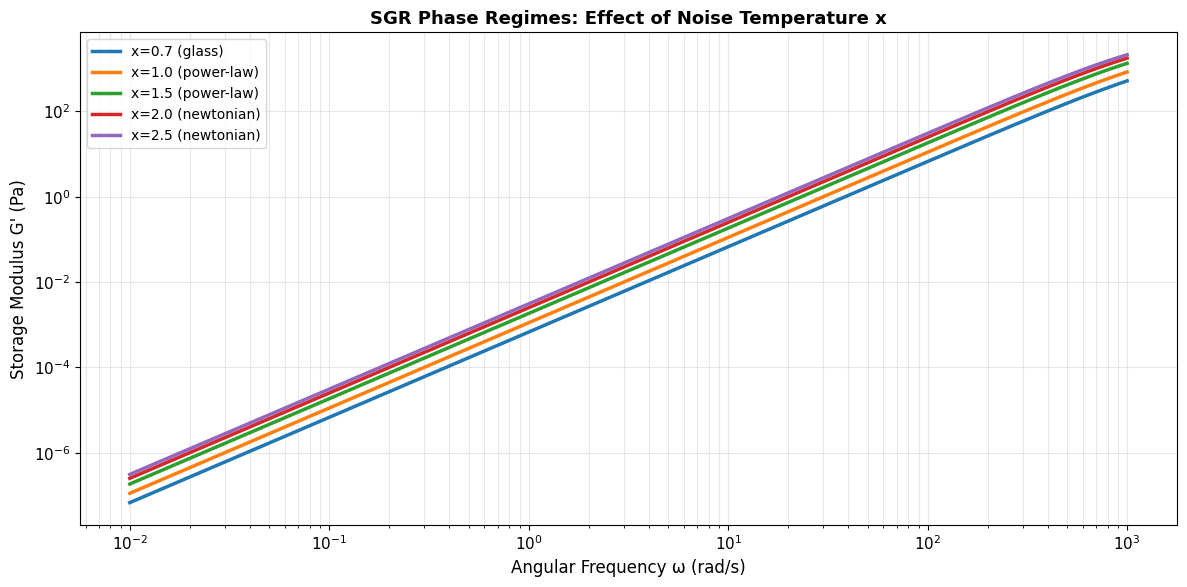

Physical interpretation of x:
  x < 1.0:  Glass phase (yield stress, solid-like, aging)
  x = 1.0:  Glass transition point (critical behavior)
  1 < x < 2: Power-law fluid (G' ~ G'' ~ ω^(x-1), viscoelastic)
  x ≥ 2.0:  Newtonian liquid (constant viscosity, fluid-like)

Application guide:
  Concentrated emulsions/foams:  x ∈ [0.6, 1.0] (near glass transition)
  Soft pastes/gels:              x ∈ [1.2, 1.8] (power-law regime)
  Dilute suspensions:            x ∈ [2.0, 2.5] (approaching Newtonian)


In [6]:
# Explore different x values
x_values = [0.7, 1.0, 1.5, 2.0, 2.5]
omega_demo = np.logspace(-2, 3, 100)

fig = plt.figure(figsize=(12, 6))

for x_val in x_values:
    # Create model with specific x
    model_demo = SGRConventional()
    model_demo.parameters.set_value('x', x_val)
    model_demo.parameters.set_value('G0', 1e4)
    model_demo.parameters.set_value('tau0', 1e-3)
    model_demo._test_mode = 'oscillation'
    
    # Predict
    G_star_demo = model_demo.predict(omega_demo)
    
    # Classify phase
    phase = model_demo.get_phase_regime()
    
    # Plot G' (similar behavior for G'')
    plt.loglog(omega_demo, G_star_demo[:, 0], linewidth=2.5, 
               label=f"x={x_val} ({phase})")

plt.xlabel('Angular Frequency ω (rad/s)', fontsize=12)
plt.ylabel("Storage Modulus G' (Pa)", fontsize=12)
plt.title('SGR Phase Regimes: Effect of Noise Temperature x', fontsize=13, fontweight='bold')
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
display(fig)
plt.close(fig)

print("Physical interpretation of x:")
print("  x < 1.0:  Glass phase (yield stress, solid-like, aging)")
print("  x = 1.0:  Glass transition point (critical behavior)")
print("  1 < x < 2: Power-law fluid (G' ~ G'' ~ ω^(x-1), viscoelastic)")
print("  x ≥ 2.0:  Newtonian liquid (constant viscosity, fluid-like)")
print("\nApplication guide:")
print("  Concentrated emulsions/foams:  x ∈ [0.6, 1.0] (near glass transition)")
print("  Soft pastes/gels:              x ∈ [1.2, 1.8] (power-law regime)")
print("  Dilute suspensions:            x ∈ [2.0, 2.5] (approaching Newtonian)")

## 5. SGRGeneric: Thermodynamically Consistent Framework

Compare SGRConventional with the GENERIC thermodynamic framework.

In [7]:
# Fit SGRGeneric to same data
sgr_gen = SGRGeneric()

print("Fitting SGRGeneric model...")
sgr_gen.fit(omega, G_star_noisy, test_mode='oscillation')

# Extract fitted parameters
x_gen = sgr_gen.parameters.get_value('x')
G0_gen = sgr_gen.parameters.get_value('G0')
tau0_gen = sgr_gen.parameters.get_value('tau0')

# Predict
G_star_gen = sgr_gen.predict(omega)

# Calculate R²
r2_prime_gen = calc_r2(G_prime_noisy, G_star_gen[:, 0])
r2_double_prime_gen = calc_r2(G_double_prime_noisy, G_star_gen[:, 1])

print("\nFitted SGRGeneric parameters:")
print(f"  x    = {x_gen:.4f}")
print(f"  G0   = {G0_gen:.2e} Pa")
print(f"  tau0 = {tau0_gen:.2e} s")
print(f"\nFit quality:")
print(f"  R² (G')  = {r2_prime_gen:.6f}")
print(f"  R² (G'') = {r2_double_prime_gen:.6f}")

# Check thermodynamic consistency
state_test = np.array([100.0, 0.5])  # [stress (Pa), structural parameter]
consistency = sgr_gen.verify_thermodynamic_consistency(state_test)

print("\nThermodynamic consistency checks:")
print(f"  Poisson bracket antisymmetric: {consistency['poisson_antisymmetric']}")
print(f"  Friction matrix symmetric: {consistency['friction_symmetric']}")
print(f"  Friction matrix PSD: {consistency['friction_positive_semidefinite']}")
print(f"  Entropy production ≥ 0: {consistency['entropy_production_nonnegative']}")
print(f"  Overall: {consistency['thermodynamically_consistent']}")
print(f"\nEntropy production rate: {consistency['entropy_production']:.6e} (must be ≥ 0)")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Fitting SGRGeneric model...


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.393075s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=0.0215 | elapsed=0.393s | final_gradient_norm=2519.0783



Fitted SGRGeneric parameters:
  x    = 1.4123
  G0   = 1.01e+04 Pa
  tau0 = 1.03e-03 s

Fit quality:
  R² (G')  = 0.999904
  R² (G'') = 0.999488

Thermodynamic consistency checks:
  Poisson bracket antisymmetric: True
  Friction matrix symmetric: True
  Friction matrix PSD: True
  Entropy production ≥ 0: True
  Overall: True

Entropy production rate: 2.509780e+03 (must be ≥ 0)


### Compare Conventional vs GENERIC Predictions

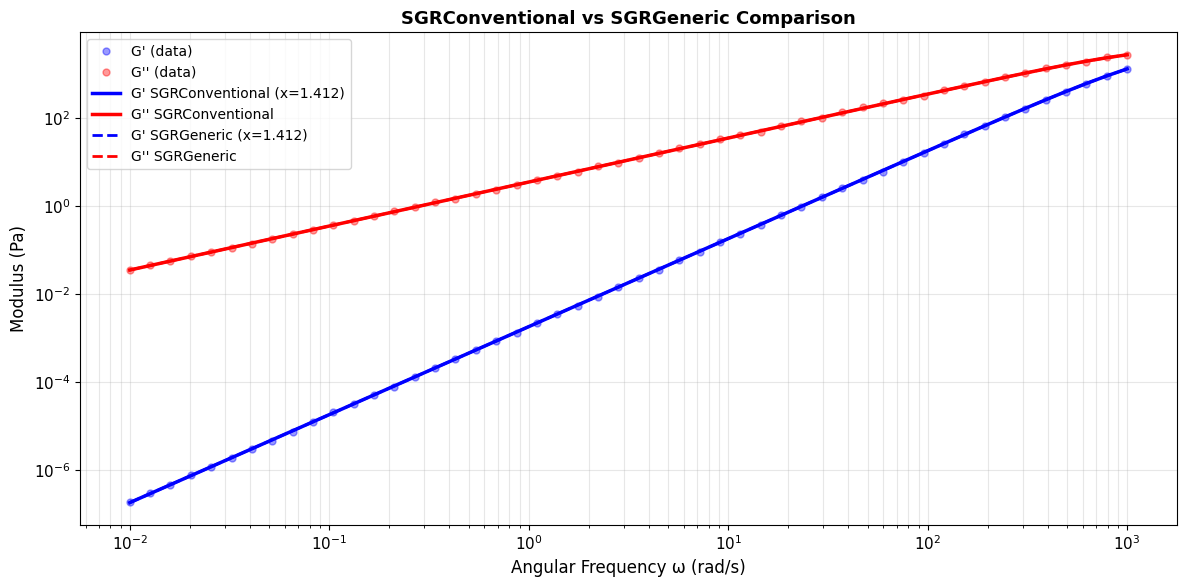

Comparison summary:
  SGRConventional: x=1.4123, R²(G')=0.999904, R²(G'')=0.999488
  SGRGeneric:      x=1.4123, R²(G')=0.999904, R²(G'')=0.999488

Conclusion: Both models provide excellent fits with nearly identical predictions.
Use SGRGeneric when thermodynamic consistency is critical.


In [8]:
# Compare predictions
fig = plt.figure(figsize=(12, 6))

plt.loglog(omega, G_prime_noisy, 'bo', markersize=5, alpha=0.4, label="G' (data)")
plt.loglog(omega, G_double_prime_noisy, 'ro', markersize=5, alpha=0.4, label="G'' (data)")
plt.loglog(omega, G_prime_pred, 'b-', linewidth=2.5, 
           label=f"G' SGRConventional (x={x_fit:.3f})")
plt.loglog(omega, G_double_prime_pred, 'r-', linewidth=2.5, 
           label=f"G'' SGRConventional")
plt.loglog(omega, G_star_gen[:, 0], 'b--', linewidth=2, 
           label=f"G' SGRGeneric (x={x_gen:.3f})")
plt.loglog(omega, G_star_gen[:, 1], 'r--', linewidth=2, 
           label=f"G'' SGRGeneric")

plt.xlabel('Angular Frequency ω (rad/s)', fontsize=12)
plt.ylabel('Modulus (Pa)', fontsize=12)
plt.title('SGRConventional vs SGRGeneric Comparison', fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
display(fig)
plt.close(fig)

print("Comparison summary:")
print(f"  SGRConventional: x={x_fit:.4f}, R²(G')={r2_prime:.6f}, R²(G'')={r2_double_prime:.6f}")
print(f"  SGRGeneric:      x={x_gen:.4f}, R²(G')={r2_prime_gen:.6f}, R²(G'')={r2_double_prime_gen:.6f}")
print("\nConclusion: Both models provide excellent fits with nearly identical predictions.")
print("Use SGRGeneric when thermodynamic consistency is critical.")

## 6. Relaxation Mode: Time-Domain Fitting

Demonstrate SGR fitting to relaxation modulus data.

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Fitting SGR to relaxation data...


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.227108s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=7 | final_cost=0.0215 | elapsed=0.227s | final_gradient_norm=0.0320



Fitted parameters (relaxation mode):
  x    = 1.4978 (true: 1.5000)
  G0   = 9.50e+03 Pa (true: 1.00e+04 Pa)
  tau0 = 1.14e-03 s (true: 1.00e-03 s)
  R²   = 0.999107


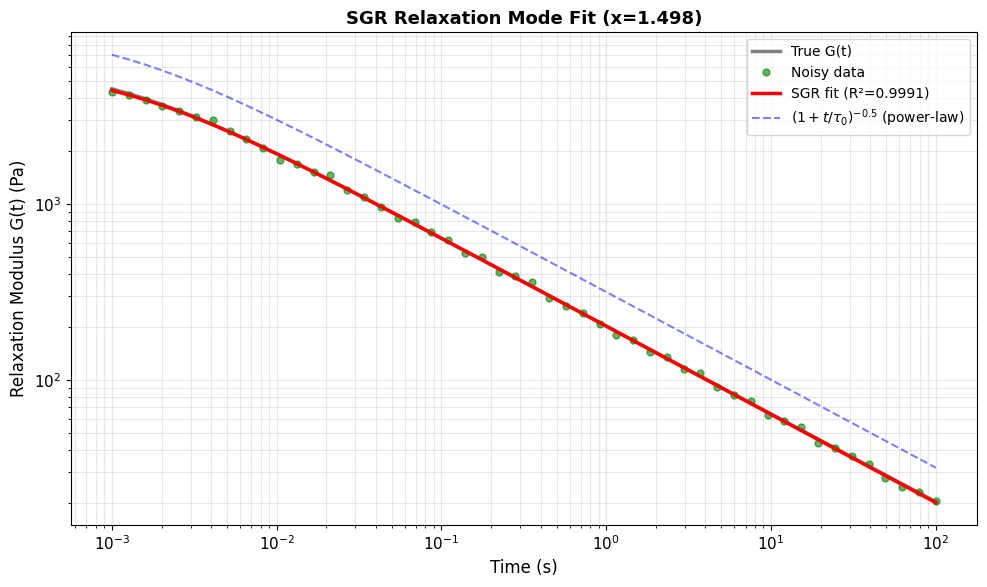


Relaxation behavior:
  Short time (t << tau0): G(t) ≈ G0 (plateau)
  Long time (t >> tau0):  G(t) ~ t^(x-2) = t^-0.50 (power-law decay)
  For x < 2: relaxation, x ≥ 2: approaches constant


In [9]:
# Generate relaxation data
t = np.logspace(-3, 2, 50)  # Time (s)

# Use same true parameters
model_relax_true = SGRConventional()
model_relax_true.parameters.set_value('x', x_true)
model_relax_true.parameters.set_value('G0', G0_true)
model_relax_true.parameters.set_value('tau0', tau0_true)
model_relax_true._test_mode = 'relaxation'

# Generate G(t)
G_t_true = model_relax_true.predict(t)

# Add noise (3% relative)
G_t_noisy = G_t_true * (1 + noise_level * np.random.randn(len(t)))

# Fit SGRConventional in relaxation mode
sgr_relax = SGRConventional()
print("Fitting SGR to relaxation data...")
sgr_relax.fit(t, G_t_noisy, test_mode='relaxation')

# Predict
G_t_pred = sgr_relax.predict(t)

# R²
r2_relax = calc_r2(G_t_noisy, G_t_pred)

# Extract parameters
x_relax = sgr_relax.parameters.get_value('x')
G0_relax = sgr_relax.parameters.get_value('G0')
tau0_relax = sgr_relax.parameters.get_value('tau0')

print(f"\nFitted parameters (relaxation mode):")
print(f"  x    = {x_relax:.4f} (true: {x_true:.4f})")
print(f"  G0   = {G0_relax:.2e} Pa (true: {G0_true:.2e} Pa)")
print(f"  tau0 = {tau0_relax:.2e} s (true: {tau0_true:.2e} s)")
print(f"  R²   = {r2_relax:.6f}")

# Plot
fig = plt.figure(figsize=(10, 6))
plt.loglog(t, G_t_true, 'k-', linewidth=2.5, alpha=0.5, label='True G(t)')
plt.loglog(t, G_t_noisy, 'go', markersize=5, alpha=0.6, label='Noisy data')
plt.loglog(t, G_t_pred, 'r-', linewidth=2.5, label=f'SGR fit (R²={r2_relax:.4f})')

# Power-law reference
power_law_t = G0_true * (1 + t/tau0_true)**(x_true - 2)
plt.loglog(t, power_law_t, 'b--', linewidth=1.5, alpha=0.5, 
           label=f'$(1+t/\\tau_0)^{{{x_true-2:.1f}}}$ (power-law)')

plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Relaxation Modulus G(t) (Pa)', fontsize=12)
plt.title(f'SGR Relaxation Mode Fit (x={x_relax:.3f})', fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
display(fig)
plt.close(fig)

print("\nRelaxation behavior:")
print(f"  Short time (t << tau0): G(t) ≈ G0 (plateau)")
print(f"  Long time (t >> tau0):  G(t) ~ t^(x-2) = t^{x_relax-2:.2f} (power-law decay)")
print(f"  For x < 2: relaxation, x ≥ 2: approaches constant")

## 7. Bayesian Inference: Uncertainty Quantification

Use Bayesian inference to quantify uncertainty in fitted SGR parameters.

In [10]:
# Bayesian inference with warm-start from NLSQ
print("Running Bayesian inference (NUTS with warm-start)...")
print("This may take 30-60 seconds...\n")

# Use SGRConventional fitted model as warm-start
result_bayes = sgr_conv.fit_bayesian(
    omega, 
    G_star_noisy, 
    test_mode='oscillation',
    num_samples=2000, 
    num_warmup=1000,
    num_chains=2
)

# Get credible intervals (returns dict[str, tuple[float, float]] = (lower, upper))
intervals = sgr_conv.get_credible_intervals(result_bayes.posterior_samples, credibility=0.95)

print("\nBayesian inference results (95% credible intervals):")
for param_name, (lower, upper) in intervals.items():
    # Compute median from posterior samples
    samples = result_bayes.posterior_samples[param_name]
    median = np.median(samples)
    
    # Get true value for comparison
    true_val = {'x': x_true, 'G0': G0_true, 'tau0': tau0_true}[param_name]
    
    print(f"  {param_name:5s}: {median:.4e} [{lower:.4e}, {upper:.4e}] (true: {true_val:.4e})")

# Get diagnostics
diagnostics = result_bayes.diagnostics

print("\nMCMC Diagnostics:")
print(f"  R-hat (all params):  {diagnostics['r_hat']}")
print(f"  ESS (all params):    {diagnostics['ess']}")
print(f"  Divergences:         {diagnostics['divergences']}")

# Check convergence criteria
r_hat_ok = all(r < 1.01 for r in diagnostics['r_hat'].values())
ess_ok = all(e > 400 for e in diagnostics['ess'].values())
div_ok = diagnostics['divergences'] < 10

print(f"\nConvergence checks:")
print(f"  R-hat < 1.01: {'PASS' if r_hat_ok else 'FAIL'}")
print(f"  ESS > 400:    {'PASS' if ess_ok else 'FAIL'}")
print(f"  Divergences < 1%: {'PASS' if div_ok else 'FAIL'}")

Running Bayesian inference (NUTS with warm-start)...
This may take 30-60 seconds...



  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   0%|          | 1/3000 [00:01<1:36:07,  1.92s/it]

warmup:   0%|          | 2/3000 [00:03<1:34:42,  1.90s/it]

warmup:   0%|          | 10/3000 [00:03<12:52,  3.87it/s] 

warmup:   1%|          | 16/3000 [00:04<07:04,  7.03it/s]

warmup:   1%|          | 21/3000 [00:04<04:57, 10.01it/s]

warmup:   1%|          | 26/3000 [00:04<03:40, 13.47it/s]

warmup:   1%|          | 31/3000 [00:04<03:02, 16.26it/s]

warmup:   1%|          | 35/3000 [00:04<02:43, 18.11it/s]

warmup:   1%|▏         | 40/3000 [00:04<02:17, 21.47it/s]

warmup:   1%|▏         | 44/3000 [00:04<02:19, 21.14it/s]

warmup:   2%|▏         | 48/3000 [00:05<02:19, 21.11it/s]

warmup:   2%|▏         | 51/3000 [00:05<02:21, 20.79it/s]

warmup:   2%|▏         | 54/3000 [00:05<02:19, 21.10it/s]

warmup:   2%|▏         | 57/3000 [00:05<02:24, 20.33it/s]

warmup:   2%|▏         | 60/3000 [00:05<02:25, 20.21it/s]

warmup:   2%|▏         | 63/3000 [00:05<02:23, 20.46it/s]

warmup:   2%|▏         | 66/3000 [00:06<02:20, 20.82it/s]

warmup:   2%|▏         | 69/3000 [00:06<02:41, 18.18it/s]

warmup:   2%|▏         | 72/3000 [00:06<02:37, 18.54it/s]

warmup:   2%|▎         | 75/3000 [00:06<02:28, 19.65it/s]

warmup:   3%|▎         | 78/3000 [00:06<02:48, 17.31it/s]

warmup:   3%|▎         | 81/3000 [00:06<02:28, 19.64it/s]

warmup:   3%|▎         | 84/3000 [00:06<02:21, 20.61it/s]

warmup:   3%|▎         | 87/3000 [00:07<02:33, 18.93it/s]

warmup:   3%|▎         | 90/3000 [00:07<03:00, 16.08it/s]

warmup:   3%|▎         | 93/3000 [00:07<02:44, 17.63it/s]

warmup:   3%|▎         | 98/3000 [00:07<02:00, 24.08it/s]

warmup:   3%|▎         | 101/3000 [00:07<02:08, 22.54it/s]

warmup:   3%|▎         | 104/3000 [00:08<02:24, 20.09it/s]

warmup:   4%|▎         | 107/3000 [00:08<02:32, 18.92it/s]

warmup:   4%|▎         | 110/3000 [00:08<02:20, 20.58it/s]

warmup:   4%|▍         | 113/3000 [00:08<02:18, 20.89it/s]

warmup:   4%|▍         | 116/3000 [00:08<03:01, 15.91it/s]

warmup:   4%|▍         | 118/3000 [00:08<03:10, 15.13it/s]

warmup:   4%|▍         | 120/3000 [00:08<02:59, 16.05it/s]

warmup:   4%|▍         | 123/3000 [00:09<02:33, 18.72it/s]

warmup:   4%|▍         | 126/3000 [00:09<02:40, 17.90it/s]

warmup:   4%|▍         | 130/3000 [00:09<02:08, 22.29it/s]

warmup:   4%|▍         | 133/3000 [00:09<02:20, 20.38it/s]

warmup:   5%|▍         | 136/3000 [00:09<02:21, 20.26it/s]

warmup:   5%|▍         | 139/3000 [00:09<02:13, 21.35it/s]

warmup:   5%|▍         | 142/3000 [00:10<02:21, 20.26it/s]

warmup:   5%|▍         | 145/3000 [00:10<02:36, 18.20it/s]

warmup:   5%|▍         | 148/3000 [00:10<02:47, 17.03it/s]

warmup:   5%|▌         | 150/3000 [00:10<03:00, 15.75it/s]

warmup:   5%|▌         | 153/3000 [00:10<02:58, 15.98it/s]

warmup:   5%|▌         | 155/3000 [00:10<02:58, 15.96it/s]

warmup:   5%|▌         | 157/3000 [00:11<02:58, 15.96it/s]

warmup:   5%|▌         | 159/3000 [00:11<03:25, 13.82it/s]

warmup:   5%|▌         | 161/3000 [00:11<03:45, 12.58it/s]

warmup:   5%|▌         | 163/3000 [00:11<04:02, 11.68it/s]

warmup:   6%|▌         | 165/3000 [00:11<04:15, 11.09it/s]

warmup:   6%|▌         | 167/3000 [00:12<04:22, 10.80it/s]

warmup:   6%|▌         | 169/3000 [00:12<04:07, 11.43it/s]

warmup:   6%|▌         | 171/3000 [00:12<04:20, 10.86it/s]

warmup:   6%|▌         | 173/3000 [00:12<03:54, 12.04it/s]

warmup:   6%|▌         | 175/3000 [00:12<03:28, 13.58it/s]

warmup:   6%|▌         | 177/3000 [00:12<03:51, 12.20it/s]

warmup:   6%|▌         | 179/3000 [00:12<04:08, 11.37it/s]

warmup:   6%|▌         | 181/3000 [00:13<04:02, 11.64it/s]

warmup:   6%|▌         | 183/3000 [00:13<03:36, 13.04it/s]

warmup:   6%|▌         | 185/3000 [00:13<04:00, 11.73it/s]

warmup:   6%|▌         | 187/3000 [00:13<03:33, 13.20it/s]

warmup:   6%|▋         | 190/3000 [00:13<03:16, 14.31it/s]

warmup:   6%|▋         | 192/3000 [00:13<03:08, 14.92it/s]

warmup:   6%|▋         | 194/3000 [00:14<03:21, 13.91it/s]

warmup:   7%|▋         | 196/3000 [00:14<03:05, 15.12it/s]

warmup:   7%|▋         | 200/3000 [00:14<02:27, 18.98it/s]

warmup:   7%|▋         | 205/3000 [00:14<01:48, 25.85it/s]

warmup:   7%|▋         | 208/3000 [00:14<02:02, 22.74it/s]

warmup:   7%|▋         | 211/3000 [00:14<01:54, 24.32it/s]

warmup:   7%|▋         | 215/3000 [00:14<01:44, 26.56it/s]

warmup:   7%|▋         | 219/3000 [00:14<01:36, 28.82it/s]

warmup:   7%|▋         | 222/3000 [00:15<01:50, 25.14it/s]

warmup:   8%|▊         | 225/3000 [00:15<01:58, 23.48it/s]

warmup:   8%|▊         | 228/3000 [00:15<02:09, 21.35it/s]

warmup:   8%|▊         | 231/3000 [00:15<02:17, 20.18it/s]

warmup:   8%|▊         | 234/3000 [00:15<02:31, 18.31it/s]

warmup:   8%|▊         | 236/3000 [00:15<02:49, 16.33it/s]

warmup:   8%|▊         | 239/3000 [00:16<02:32, 18.15it/s]

warmup:   8%|▊         | 242/3000 [00:16<02:23, 19.22it/s]

warmup:   8%|▊         | 244/3000 [00:16<02:38, 17.36it/s]

warmup:   8%|▊         | 246/3000 [00:16<02:35, 17.74it/s]

warmup:   8%|▊         | 248/3000 [00:16<02:43, 16.83it/s]

warmup:   8%|▊         | 250/3000 [00:16<03:13, 14.18it/s]

warmup:   8%|▊         | 253/3000 [00:16<02:52, 15.91it/s]

warmup:   8%|▊         | 255/3000 [00:17<03:21, 13.63it/s]

warmup:   9%|▊         | 257/3000 [00:17<03:31, 12.98it/s]

warmup:   9%|▊         | 259/3000 [00:17<03:47, 12.05it/s]

warmup:   9%|▊         | 261/3000 [00:17<03:27, 13.18it/s]

warmup:   9%|▉         | 263/3000 [00:17<03:47, 12.05it/s]

warmup:   9%|▉         | 265/3000 [00:18<04:00, 11.39it/s]

warmup:   9%|▉         | 267/3000 [00:18<03:42, 12.28it/s]

warmup:   9%|▉         | 270/3000 [00:18<03:20, 13.60it/s]

warmup:   9%|▉         | 273/3000 [00:18<02:45, 16.46it/s]

warmup:   9%|▉         | 276/3000 [00:18<02:37, 17.31it/s]

warmup:   9%|▉         | 278/3000 [00:18<02:43, 16.64it/s]

warmup:   9%|▉         | 280/3000 [00:18<02:36, 17.37it/s]

warmup:   9%|▉         | 283/3000 [00:19<02:38, 17.11it/s]

warmup:  10%|▉         | 285/3000 [00:19<03:01, 14.98it/s]

warmup:  10%|▉         | 287/3000 [00:19<02:54, 15.51it/s]

warmup:  10%|▉         | 289/3000 [00:19<03:04, 14.68it/s]

warmup:  10%|▉         | 291/3000 [00:19<03:19, 13.58it/s]

warmup:  10%|▉         | 293/3000 [00:19<03:21, 13.46it/s]

warmup:  10%|▉         | 295/3000 [00:20<03:40, 12.26it/s]

warmup:  10%|▉         | 298/3000 [00:20<03:15, 13.82it/s]

warmup:  10%|█         | 302/3000 [00:20<02:46, 16.21it/s]

warmup:  10%|█         | 305/3000 [00:20<02:36, 17.19it/s]

warmup:  10%|█         | 307/3000 [00:20<02:35, 17.33it/s]

warmup:  10%|█         | 311/3000 [00:20<02:08, 20.97it/s]

warmup:  10%|█         | 314/3000 [00:20<02:18, 19.42it/s]

warmup:  11%|█         | 316/3000 [00:21<02:46, 16.13it/s]

warmup:  11%|█         | 318/3000 [00:21<02:58, 15.04it/s]

warmup:  11%|█         | 321/3000 [00:21<02:41, 16.55it/s]

warmup:  11%|█         | 323/3000 [00:21<03:06, 14.33it/s]

warmup:  11%|█         | 325/3000 [00:21<03:20, 13.32it/s]

warmup:  11%|█         | 327/3000 [00:21<03:20, 13.36it/s]

warmup:  11%|█         | 329/3000 [00:22<03:19, 13.37it/s]

warmup:  11%|█         | 331/3000 [00:22<03:23, 13.11it/s]

warmup:  11%|█         | 333/3000 [00:22<03:21, 13.23it/s]

warmup:  11%|█         | 335/3000 [00:22<03:20, 13.31it/s]

warmup:  11%|█         | 337/3000 [00:22<03:38, 12.17it/s]

warmup:  11%|█▏        | 339/3000 [00:22<03:50, 11.55it/s]

warmup:  11%|█▏        | 341/3000 [00:23<03:23, 13.09it/s]

warmup:  11%|█▏        | 344/3000 [00:23<03:09, 14.02it/s]

warmup:  12%|█▏        | 347/3000 [00:23<02:55, 15.08it/s]

warmup:  12%|█▏        | 350/3000 [00:23<02:45, 15.98it/s]

warmup:  12%|█▏        | 353/3000 [00:23<02:32, 17.34it/s]

warmup:  12%|█▏        | 355/3000 [00:23<02:42, 16.24it/s]

warmup:  12%|█▏        | 357/3000 [00:24<02:52, 15.35it/s]

warmup:  12%|█▏        | 359/3000 [00:24<02:59, 14.70it/s]

warmup:  12%|█▏        | 361/3000 [00:24<03:23, 12.95it/s]

warmup:  12%|█▏        | 363/3000 [00:24<03:40, 11.98it/s]

warmup:  12%|█▏        | 366/3000 [00:24<03:20, 13.11it/s]

warmup:  12%|█▏        | 368/3000 [00:24<03:29, 12.53it/s]

warmup:  12%|█▏        | 371/3000 [00:25<02:58, 14.73it/s]

warmup:  12%|█▏        | 373/3000 [00:25<03:18, 13.22it/s]

warmup:  12%|█▎        | 375/3000 [00:25<03:35, 12.21it/s]

warmup:  13%|█▎        | 377/3000 [00:25<03:48, 11.48it/s]

warmup:  13%|█▎        | 379/3000 [00:25<03:56, 11.07it/s]

warmup:  13%|█▎        | 381/3000 [00:26<03:37, 12.02it/s]

warmup:  13%|█▎        | 383/3000 [00:26<04:07, 10.59it/s]

warmup:  13%|█▎        | 385/3000 [00:26<04:05, 10.65it/s]

warmup:  13%|█▎        | 387/3000 [00:26<04:15, 10.22it/s]

warmup:  13%|█▎        | 389/3000 [00:26<04:26,  9.80it/s]

warmup:  13%|█▎        | 391/3000 [00:27<04:00, 10.83it/s]

warmup:  13%|█▎        | 393/3000 [00:27<03:34, 12.15it/s]

warmup:  13%|█▎        | 395/3000 [00:27<03:12, 13.50it/s]

warmup:  13%|█▎        | 397/3000 [00:27<03:31, 12.29it/s]

warmup:  13%|█▎        | 399/3000 [00:27<03:19, 13.04it/s]

warmup:  13%|█▎        | 401/3000 [00:27<03:01, 14.35it/s]

warmup:  13%|█▎        | 404/3000 [00:27<02:46, 15.60it/s]

warmup:  14%|█▎        | 406/3000 [00:27<02:37, 16.50it/s]

warmup:  14%|█▎        | 408/3000 [00:28<02:39, 16.29it/s]

warmup:  14%|█▎        | 410/3000 [00:28<02:40, 16.12it/s]

warmup:  14%|█▍        | 413/3000 [00:28<02:21, 18.23it/s]

warmup:  14%|█▍        | 415/3000 [00:28<02:51, 15.09it/s]

warmup:  14%|█▍        | 417/3000 [00:28<02:45, 15.57it/s]

warmup:  14%|█▍        | 419/3000 [00:28<03:11, 13.51it/s]

warmup:  14%|█▍        | 421/3000 [00:29<03:02, 14.13it/s]

warmup:  14%|█▍        | 423/3000 [00:29<03:21, 12.80it/s]

warmup:  14%|█▍        | 425/3000 [00:29<03:21, 12.79it/s]

warmup:  14%|█▍        | 428/3000 [00:29<02:59, 14.36it/s]

warmup:  14%|█▍        | 430/3000 [00:29<02:49, 15.15it/s]

warmup:  14%|█▍        | 434/3000 [00:29<02:20, 18.32it/s]

warmup:  15%|█▍        | 437/3000 [00:29<02:21, 18.09it/s]

warmup:  15%|█▍        | 439/3000 [00:30<02:18, 18.43it/s]

warmup:  15%|█▍        | 441/3000 [00:30<02:31, 16.87it/s]

warmup:  15%|█▍        | 444/3000 [00:30<02:26, 17.40it/s]

warmup:  15%|█▍        | 446/3000 [00:30<02:29, 17.03it/s]

warmup:  15%|█▍        | 449/3000 [00:30<02:26, 17.44it/s]

warmup:  15%|█▌        | 451/3000 [00:30<02:22, 17.84it/s]

warmup:  15%|█▌        | 455/3000 [00:30<02:11, 19.29it/s]

warmup:  15%|█▌        | 457/3000 [00:31<02:18, 18.41it/s]

warmup:  15%|█▌        | 459/3000 [00:31<02:53, 14.67it/s]

warmup:  15%|█▌        | 461/3000 [00:31<03:12, 13.21it/s]

warmup:  15%|█▌        | 463/3000 [00:31<03:08, 13.44it/s]

warmup:  16%|█▌        | 465/3000 [00:31<03:21, 12.57it/s]

warmup:  16%|█▌        | 467/3000 [00:31<03:04, 13.73it/s]

warmup:  16%|█▌        | 470/3000 [00:32<02:39, 15.91it/s]

warmup:  16%|█▌        | 472/3000 [00:32<03:03, 13.79it/s]

warmup:  16%|█▌        | 474/3000 [00:32<03:20, 12.57it/s]

warmup:  16%|█▌        | 476/3000 [00:32<03:24, 12.34it/s]

warmup:  16%|█▌        | 478/3000 [00:32<03:17, 12.77it/s]

warmup:  16%|█▌        | 480/3000 [00:32<03:23, 12.39it/s]

warmup:  16%|█▌        | 482/3000 [00:33<03:27, 12.13it/s]

warmup:  16%|█▌        | 484/3000 [00:33<03:40, 11.40it/s]

warmup:  16%|█▌        | 486/3000 [00:33<03:20, 12.53it/s]

warmup:  16%|█▋        | 488/3000 [00:33<03:06, 13.46it/s]

warmup:  16%|█▋        | 491/3000 [00:33<02:37, 15.91it/s]

warmup:  16%|█▋        | 493/3000 [00:33<02:46, 15.08it/s]

warmup:  16%|█▋        | 495/3000 [00:34<02:48, 14.82it/s]

warmup:  17%|█▋        | 497/3000 [00:34<02:47, 14.95it/s]

warmup:  17%|█▋        | 499/3000 [00:34<02:54, 14.29it/s]

warmup:  17%|█▋        | 501/3000 [00:34<02:44, 15.22it/s]

warmup:  17%|█▋        | 504/3000 [00:34<02:14, 18.54it/s]

warmup:  17%|█▋        | 506/3000 [00:34<02:19, 17.84it/s]

warmup:  17%|█▋        | 512/3000 [00:34<01:36, 25.77it/s]

warmup:  17%|█▋        | 515/3000 [00:35<02:17, 18.05it/s]

warmup:  17%|█▋        | 518/3000 [00:35<02:19, 17.73it/s]

warmup:  17%|█▋        | 520/3000 [00:35<02:26, 16.90it/s]

warmup:  17%|█▋        | 524/3000 [00:35<02:05, 19.70it/s]

warmup:  18%|█▊        | 527/3000 [00:35<02:03, 19.98it/s]

warmup:  18%|█▊        | 530/3000 [00:35<02:17, 17.94it/s]

warmup:  18%|█▊        | 532/3000 [00:35<02:16, 18.11it/s]

warmup:  18%|█▊        | 534/3000 [00:36<02:20, 17.56it/s]

warmup:  18%|█▊        | 537/3000 [00:36<02:24, 17.10it/s]

warmup:  18%|█▊        | 539/3000 [00:36<02:35, 15.79it/s]

warmup:  18%|█▊        | 541/3000 [00:36<02:28, 16.58it/s]

warmup:  18%|█▊        | 543/3000 [00:36<02:32, 16.11it/s]

warmup:  18%|█▊        | 545/3000 [00:36<02:34, 15.85it/s]

warmup:  18%|█▊        | 547/3000 [00:36<02:29, 16.38it/s]

warmup:  18%|█▊        | 552/3000 [00:37<01:43, 23.56it/s]

warmup:  18%|█▊        | 555/3000 [00:37<02:06, 19.36it/s]

warmup:  19%|█▊        | 558/3000 [00:37<01:57, 20.72it/s]

warmup:  19%|█▊        | 561/3000 [00:37<02:02, 19.97it/s]

warmup:  19%|█▉        | 564/3000 [00:37<02:29, 16.28it/s]

warmup:  19%|█▉        | 568/3000 [00:38<02:13, 18.18it/s]

warmup:  19%|█▉        | 570/3000 [00:38<02:21, 17.19it/s]

warmup:  19%|█▉        | 572/3000 [00:38<02:24, 16.83it/s]

warmup:  19%|█▉        | 575/3000 [00:38<02:07, 18.99it/s]

warmup:  19%|█▉        | 577/3000 [00:38<02:16, 17.76it/s]

warmup:  19%|█▉        | 579/3000 [00:38<02:20, 17.27it/s]

warmup:  19%|█▉        | 581/3000 [00:38<02:30, 16.03it/s]

warmup:  19%|█▉        | 583/3000 [00:38<02:31, 15.96it/s]

warmup:  20%|█▉        | 585/3000 [00:39<02:25, 16.58it/s]

warmup:  20%|█▉        | 589/3000 [00:39<02:11, 18.29it/s]

warmup:  20%|█▉        | 591/3000 [00:39<02:16, 17.60it/s]

warmup:  20%|█▉        | 593/3000 [00:39<02:22, 16.89it/s]

warmup:  20%|█▉        | 595/3000 [00:39<02:31, 15.83it/s]

warmup:  20%|█▉        | 598/3000 [00:39<02:24, 16.60it/s]

warmup:  20%|██        | 601/3000 [00:39<02:26, 16.43it/s]

warmup:  20%|██        | 604/3000 [00:40<02:09, 18.53it/s]

warmup:  20%|██        | 606/3000 [00:40<02:09, 18.53it/s]

warmup:  20%|██        | 609/3000 [00:40<02:02, 19.45it/s]

warmup:  20%|██        | 612/3000 [00:40<02:03, 19.31it/s]

warmup:  20%|██        | 614/3000 [00:40<02:26, 16.33it/s]

warmup:  21%|██        | 617/3000 [00:40<02:14, 17.76it/s]

warmup:  21%|██        | 620/3000 [00:40<02:08, 18.45it/s]

warmup:  21%|██        | 622/3000 [00:41<02:11, 18.02it/s]

warmup:  21%|██        | 625/3000 [00:41<01:56, 20.43it/s]

warmup:  21%|██        | 629/3000 [00:41<01:51, 21.34it/s]

warmup:  21%|██        | 632/3000 [00:41<01:53, 20.90it/s]

warmup:  21%|██        | 636/3000 [00:41<01:50, 21.40it/s]

warmup:  21%|██▏       | 639/3000 [00:41<02:06, 18.67it/s]

warmup:  21%|██▏       | 643/3000 [00:42<01:53, 20.71it/s]

warmup:  22%|██▏       | 646/3000 [00:42<02:04, 18.94it/s]

warmup:  22%|██▏       | 649/3000 [00:42<02:00, 19.45it/s]

warmup:  22%|██▏       | 651/3000 [00:42<02:19, 16.82it/s]

warmup:  22%|██▏       | 653/3000 [00:42<02:17, 17.05it/s]

warmup:  22%|██▏       | 657/3000 [00:42<01:54, 20.38it/s]

warmup:  22%|██▏       | 660/3000 [00:42<01:51, 21.05it/s]

warmup:  22%|██▏       | 663/3000 [00:43<01:55, 20.26it/s]

warmup:  22%|██▏       | 666/3000 [00:43<02:12, 17.59it/s]

warmup:  22%|██▏       | 669/3000 [00:43<02:02, 19.01it/s]

warmup:  22%|██▏       | 671/3000 [00:43<02:03, 18.92it/s]

warmup:  22%|██▏       | 673/3000 [00:43<02:03, 18.86it/s]

warmup:  23%|██▎       | 676/3000 [00:43<01:48, 21.39it/s]

warmup:  23%|██▎       | 679/3000 [00:43<01:42, 22.74it/s]

warmup:  23%|██▎       | 682/3000 [00:44<01:58, 19.62it/s]

warmup:  23%|██▎       | 685/3000 [00:44<02:21, 16.38it/s]

warmup:  23%|██▎       | 687/3000 [00:44<02:22, 16.21it/s]

warmup:  23%|██▎       | 690/3000 [00:44<02:07, 18.07it/s]

warmup:  23%|██▎       | 692/3000 [00:44<02:22, 16.15it/s]

warmup:  23%|██▎       | 695/3000 [00:44<02:11, 17.49it/s]

warmup:  23%|██▎       | 697/3000 [00:45<02:09, 17.75it/s]

warmup:  23%|██▎       | 699/3000 [00:45<02:18, 16.65it/s]

warmup:  23%|██▎       | 701/3000 [00:45<02:14, 17.13it/s]

warmup:  23%|██▎       | 703/3000 [00:45<02:23, 16.00it/s]

warmup:  24%|██▎       | 706/3000 [00:45<02:19, 16.46it/s]

warmup:  24%|██▎       | 709/3000 [00:45<01:59, 19.23it/s]

warmup:  24%|██▎       | 712/3000 [00:45<02:10, 17.48it/s]

warmup:  24%|██▍       | 715/3000 [00:46<02:00, 18.99it/s]

warmup:  24%|██▍       | 718/3000 [00:46<01:48, 21.12it/s]

warmup:  24%|██▍       | 721/3000 [00:46<01:40, 22.58it/s]

warmup:  24%|██▍       | 724/3000 [00:46<02:07, 17.87it/s]

warmup:  24%|██▍       | 727/3000 [00:46<01:53, 19.94it/s]

warmup:  24%|██▍       | 730/3000 [00:46<02:16, 16.57it/s]

warmup:  24%|██▍       | 734/3000 [00:47<02:03, 18.29it/s]

warmup:  25%|██▍       | 737/3000 [00:47<02:16, 16.59it/s]

warmup:  25%|██▍       | 739/3000 [00:47<02:11, 17.20it/s]

warmup:  25%|██▍       | 741/3000 [00:47<02:19, 16.17it/s]

warmup:  25%|██▍       | 743/3000 [00:47<02:16, 16.54it/s]

warmup:  25%|██▍       | 749/3000 [00:47<01:27, 25.67it/s]

warmup:  25%|██▌       | 752/3000 [00:47<01:41, 22.10it/s]

warmup:  25%|██▌       | 757/3000 [00:48<01:24, 26.49it/s]

warmup:  25%|██▌       | 760/3000 [00:48<01:56, 19.24it/s]

warmup:  25%|██▌       | 763/3000 [00:48<02:02, 18.21it/s]

warmup:  26%|██▌       | 767/3000 [00:48<01:57, 19.08it/s]

warmup:  26%|██▌       | 770/3000 [00:48<02:06, 17.66it/s]

warmup:  26%|██▌       | 772/3000 [00:49<02:13, 16.75it/s]

warmup:  26%|██▌       | 775/3000 [00:49<02:03, 17.97it/s]

warmup:  26%|██▌       | 777/3000 [00:49<02:19, 15.97it/s]

warmup:  26%|██▌       | 779/3000 [00:49<02:22, 15.60it/s]

warmup:  26%|██▌       | 781/3000 [00:49<02:22, 15.52it/s]

warmup:  26%|██▌       | 784/3000 [00:49<02:19, 15.88it/s]

warmup:  26%|██▌       | 786/3000 [00:49<02:18, 16.04it/s]

warmup:  26%|██▋       | 789/3000 [00:50<02:20, 15.69it/s]

warmup:  26%|██▋       | 792/3000 [00:50<02:03, 17.86it/s]

warmup:  26%|██▋       | 795/3000 [00:50<01:47, 20.49it/s]

warmup:  27%|██▋       | 798/3000 [00:50<01:49, 20.02it/s]

warmup:  27%|██▋       | 801/3000 [00:50<01:42, 21.35it/s]

warmup:  27%|██▋       | 804/3000 [00:50<01:40, 21.76it/s]

warmup:  27%|██▋       | 807/3000 [00:50<01:49, 20.06it/s]

warmup:  27%|██▋       | 810/3000 [00:51<01:51, 19.62it/s]

warmup:  27%|██▋       | 813/3000 [00:51<02:16, 15.97it/s]

warmup:  27%|██▋       | 816/3000 [00:51<01:58, 18.37it/s]

warmup:  27%|██▋       | 819/3000 [00:51<01:55, 18.85it/s]

warmup:  27%|██▋       | 822/3000 [00:51<01:50, 19.78it/s]

warmup:  28%|██▊       | 825/3000 [00:51<02:00, 18.09it/s]

warmup:  28%|██▊       | 831/3000 [00:52<01:27, 24.66it/s]

warmup:  28%|██▊       | 834/3000 [00:52<01:33, 23.20it/s]

warmup:  28%|██▊       | 837/3000 [00:52<01:43, 20.93it/s]

warmup:  28%|██▊       | 840/3000 [00:52<01:53, 18.98it/s]

warmup:  28%|██▊       | 842/3000 [00:52<02:15, 15.98it/s]

warmup:  28%|██▊       | 844/3000 [00:52<02:13, 16.20it/s]

warmup:  28%|██▊       | 849/3000 [00:53<01:45, 20.45it/s]

warmup:  28%|██▊       | 852/3000 [00:53<01:50, 19.51it/s]

warmup:  28%|██▊       | 854/3000 [00:53<01:57, 18.20it/s]

warmup:  29%|██▊       | 856/3000 [00:53<02:20, 15.30it/s]

warmup:  29%|██▊       | 858/3000 [00:53<02:17, 15.54it/s]

warmup:  29%|██▊       | 860/3000 [00:53<02:27, 14.46it/s]

warmup:  29%|██▊       | 862/3000 [00:54<02:31, 14.11it/s]

warmup:  29%|██▉       | 864/3000 [00:54<02:49, 12.63it/s]

warmup:  29%|██▉       | 867/3000 [00:54<02:25, 14.65it/s]

warmup:  29%|██▉       | 869/3000 [00:54<02:42, 13.10it/s]

warmup:  29%|██▉       | 871/3000 [00:54<02:42, 13.09it/s]

warmup:  29%|██▉       | 874/3000 [00:54<02:11, 16.13it/s]

warmup:  29%|██▉       | 876/3000 [00:55<02:18, 15.28it/s]

warmup:  29%|██▉       | 878/3000 [00:55<02:11, 16.19it/s]

warmup:  29%|██▉       | 883/3000 [00:55<01:47, 19.70it/s]

warmup:  30%|██▉       | 885/3000 [00:55<02:09, 16.28it/s]

warmup:  30%|██▉       | 887/3000 [00:55<02:22, 14.79it/s]

warmup:  30%|██▉       | 889/3000 [00:55<02:24, 14.63it/s]

warmup:  30%|██▉       | 892/3000 [00:56<02:19, 15.13it/s]

warmup:  30%|██▉       | 894/3000 [00:56<02:13, 15.74it/s]

warmup:  30%|██▉       | 896/3000 [00:56<02:06, 16.64it/s]

warmup:  30%|██▉       | 898/3000 [00:56<02:25, 14.41it/s]

warmup:  30%|███       | 901/3000 [00:56<02:06, 16.60it/s]

warmup:  30%|███       | 903/3000 [00:56<02:02, 17.07it/s]

warmup:  30%|███       | 906/3000 [00:56<01:49, 19.12it/s]

warmup:  30%|███       | 909/3000 [00:56<01:40, 20.87it/s]

warmup:  30%|███       | 912/3000 [00:57<01:51, 18.81it/s]

warmup:  30%|███       | 915/3000 [00:57<01:51, 18.68it/s]

warmup:  31%|███       | 918/3000 [00:57<01:44, 19.92it/s]

warmup:  31%|███       | 921/3000 [00:57<02:07, 16.32it/s]

warmup:  31%|███       | 923/3000 [00:57<02:25, 14.30it/s]

warmup:  31%|███       | 926/3000 [00:58<02:03, 16.82it/s]

warmup:  31%|███       | 928/3000 [00:58<02:17, 15.02it/s]

warmup:  31%|███       | 930/3000 [00:58<02:16, 15.21it/s]

warmup:  31%|███       | 932/3000 [00:58<02:09, 15.94it/s]

warmup:  31%|███       | 934/3000 [00:58<02:29, 13.79it/s]

warmup:  31%|███       | 936/3000 [00:58<02:38, 13.00it/s]

warmup:  31%|███▏      | 939/3000 [00:58<02:16, 15.09it/s]

warmup:  31%|███▏      | 941/3000 [00:59<02:08, 16.01it/s]

warmup:  31%|███▏      | 943/3000 [00:59<02:01, 16.90it/s]

warmup:  32%|███▏      | 947/3000 [00:59<01:50, 18.57it/s]

warmup:  32%|███▏      | 949/3000 [00:59<02:00, 17.04it/s]

warmup:  32%|███▏      | 953/3000 [00:59<01:36, 21.21it/s]

warmup:  32%|███▏      | 956/3000 [00:59<01:40, 20.30it/s]

warmup:  32%|███▏      | 959/3000 [01:00<02:04, 16.38it/s]

warmup:  32%|███▏      | 961/3000 [01:00<02:07, 16.05it/s]

warmup:  32%|███▏      | 963/3000 [01:00<02:03, 16.48it/s]

warmup:  32%|███▏      | 965/3000 [01:00<02:23, 14.18it/s]

warmup:  32%|███▏      | 967/3000 [01:00<02:38, 12.82it/s]

warmup:  32%|███▏      | 969/3000 [01:00<02:50, 11.93it/s]

warmup:  32%|███▏      | 971/3000 [01:01<02:59, 11.30it/s]

warmup:  32%|███▏      | 973/3000 [01:01<02:41, 12.57it/s]

warmup:  33%|███▎      | 976/3000 [01:01<02:12, 15.27it/s]

warmup:  33%|███▎      | 978/3000 [01:01<02:17, 14.69it/s]

warmup:  33%|███▎      | 980/3000 [01:01<02:35, 13.00it/s]

warmup:  33%|███▎      | 982/3000 [01:01<02:48, 11.99it/s]

warmup:  33%|███▎      | 984/3000 [01:02<02:44, 12.29it/s]

warmup:  33%|███▎      | 986/3000 [01:02<02:31, 13.27it/s]

warmup:  33%|███▎      | 988/3000 [01:02<02:45, 12.18it/s]

warmup:  33%|███▎      | 990/3000 [01:02<02:26, 13.75it/s]

warmup:  33%|███▎      | 992/3000 [01:02<02:27, 13.62it/s]

warmup:  33%|███▎      | 994/3000 [01:02<02:24, 13.89it/s]

warmup:  33%|███▎      | 999/3000 [01:02<01:36, 20.68it/s]

sample:  33%|███▎      | 1002/3000 [01:03<01:44, 19.07it/s]

sample:  34%|███▎      | 1005/3000 [01:03<01:38, 20.32it/s]

sample:  34%|███▎      | 1008/3000 [01:03<01:38, 20.17it/s]

sample:  34%|███▎      | 1011/3000 [01:03<02:00, 16.53it/s]

sample:  34%|███▍      | 1015/3000 [01:03<01:50, 17.99it/s]

sample:  34%|███▍      | 1017/3000 [01:03<01:58, 16.68it/s]

sample:  34%|███▍      | 1020/3000 [01:04<01:43, 19.12it/s]

sample:  34%|███▍      | 1023/3000 [01:04<01:53, 17.48it/s]

sample:  34%|███▍      | 1026/3000 [01:04<01:39, 19.80it/s]

sample:  34%|███▍      | 1029/3000 [01:04<01:45, 18.64it/s]

sample:  34%|███▍      | 1032/3000 [01:04<01:35, 20.65it/s]

sample:  34%|███▍      | 1035/3000 [01:04<01:34, 20.77it/s]

sample:  35%|███▍      | 1038/3000 [01:04<01:41, 19.42it/s]

sample:  35%|███▍      | 1041/3000 [01:05<01:59, 16.41it/s]

sample:  35%|███▍      | 1044/3000 [01:05<01:47, 18.21it/s]

sample:  35%|███▍      | 1047/3000 [01:05<01:37, 19.97it/s]

sample:  35%|███▌      | 1050/3000 [01:05<01:43, 18.91it/s]

sample:  35%|███▌      | 1053/3000 [01:05<01:57, 16.55it/s]

sample:  35%|███▌      | 1055/3000 [01:05<01:56, 16.74it/s]

sample:  35%|███▌      | 1059/3000 [01:06<01:44, 18.65it/s]

sample:  35%|███▌      | 1061/3000 [01:06<01:42, 18.92it/s]

sample:  35%|███▌      | 1063/3000 [01:06<02:04, 15.60it/s]

sample:  36%|███▌      | 1065/3000 [01:06<02:00, 16.04it/s]

sample:  36%|███▌      | 1067/3000 [01:06<02:16, 14.16it/s]

sample:  36%|███▌      | 1069/3000 [01:06<02:20, 13.74it/s]

sample:  36%|███▌      | 1071/3000 [01:07<02:21, 13.64it/s]

sample:  36%|███▌      | 1074/3000 [01:07<01:57, 16.45it/s]

sample:  36%|███▌      | 1076/3000 [01:07<01:59, 16.15it/s]

sample:  36%|███▌      | 1078/3000 [01:07<02:17, 14.02it/s]

sample:  36%|███▌      | 1080/3000 [01:07<02:17, 14.00it/s]

sample:  36%|███▌      | 1082/3000 [01:07<02:32, 12.55it/s]

sample:  36%|███▌      | 1085/3000 [01:07<02:06, 15.12it/s]

sample:  36%|███▌      | 1087/3000 [01:08<01:58, 16.08it/s]

sample:  36%|███▋      | 1089/3000 [01:08<02:09, 14.75it/s]

sample:  36%|███▋      | 1091/3000 [01:08<02:04, 15.33it/s]

sample:  36%|███▋      | 1094/3000 [01:08<01:48, 17.57it/s]

sample:  37%|███▋      | 1097/3000 [01:08<01:33, 20.28it/s]

sample:  37%|███▋      | 1100/3000 [01:08<01:43, 18.41it/s]

sample:  37%|███▋      | 1102/3000 [01:08<01:42, 18.43it/s]

sample:  37%|███▋      | 1104/3000 [01:09<01:53, 16.76it/s]

sample:  37%|███▋      | 1106/3000 [01:09<02:04, 15.21it/s]

sample:  37%|███▋      | 1109/3000 [01:09<01:46, 17.79it/s]

sample:  37%|███▋      | 1112/3000 [01:09<01:42, 18.42it/s]

sample:  37%|███▋      | 1114/3000 [01:09<01:47, 17.53it/s]

sample:  37%|███▋      | 1116/3000 [01:09<01:56, 16.21it/s]

sample:  37%|███▋      | 1119/3000 [01:09<01:51, 16.82it/s]

sample:  37%|███▋      | 1121/3000 [01:10<02:08, 14.57it/s]

sample:  37%|███▋      | 1124/3000 [01:10<01:51, 16.77it/s]

sample:  38%|███▊      | 1126/3000 [01:10<01:48, 17.22it/s]

sample:  38%|███▊      | 1130/3000 [01:10<01:33, 19.99it/s]

sample:  38%|███▊      | 1133/3000 [01:10<01:51, 16.82it/s]

sample:  38%|███▊      | 1136/3000 [01:10<01:35, 19.43it/s]

sample:  38%|███▊      | 1139/3000 [01:10<01:36, 19.30it/s]

sample:  38%|███▊      | 1142/3000 [01:11<01:38, 18.91it/s]

sample:  38%|███▊      | 1144/3000 [01:11<01:42, 18.18it/s]

sample:  38%|███▊      | 1146/3000 [01:11<02:02, 15.18it/s]

sample:  38%|███▊      | 1149/3000 [01:11<01:52, 16.50it/s]

sample:  38%|███▊      | 1151/3000 [01:11<01:58, 15.58it/s]

sample:  38%|███▊      | 1154/3000 [01:11<01:42, 18.07it/s]

sample:  39%|███▊      | 1158/3000 [01:12<01:23, 22.12it/s]

sample:  39%|███▊      | 1161/3000 [01:12<01:31, 20.00it/s]

sample:  39%|███▉      | 1164/3000 [01:12<01:46, 17.16it/s]

sample:  39%|███▉      | 1166/3000 [01:12<01:54, 16.06it/s]

sample:  39%|███▉      | 1168/3000 [01:12<01:58, 15.51it/s]

sample:  39%|███▉      | 1172/3000 [01:12<01:33, 19.54it/s]

sample:  39%|███▉      | 1175/3000 [01:12<01:27, 20.81it/s]

sample:  39%|███▉      | 1178/3000 [01:13<01:35, 19.10it/s]

sample:  39%|███▉      | 1181/3000 [01:13<01:28, 20.64it/s]

sample:  39%|███▉      | 1184/3000 [01:13<01:40, 18.08it/s]

sample:  40%|███▉      | 1186/3000 [01:13<01:39, 18.15it/s]

sample:  40%|███▉      | 1188/3000 [01:13<01:52, 16.10it/s]

sample:  40%|███▉      | 1192/3000 [01:13<01:29, 20.13it/s]

sample:  40%|███▉      | 1195/3000 [01:14<01:28, 20.33it/s]

sample:  40%|███▉      | 1198/3000 [01:14<01:36, 18.62it/s]

sample:  40%|████      | 1200/3000 [01:14<01:55, 15.63it/s]

sample:  40%|████      | 1202/3000 [01:14<02:11, 13.68it/s]

sample:  40%|████      | 1204/3000 [01:14<02:15, 13.30it/s]

sample:  40%|████      | 1206/3000 [01:14<02:14, 13.29it/s]

sample:  40%|████      | 1209/3000 [01:15<01:51, 16.05it/s]

sample:  40%|████      | 1211/3000 [01:15<02:04, 14.38it/s]

sample:  40%|████      | 1215/3000 [01:15<01:43, 17.22it/s]

sample:  41%|████      | 1217/3000 [01:15<02:01, 14.67it/s]

sample:  41%|████      | 1219/3000 [01:15<02:02, 14.56it/s]

sample:  41%|████      | 1221/3000 [01:15<02:06, 14.06it/s]

sample:  41%|████      | 1224/3000 [01:16<01:45, 16.88it/s]

sample:  41%|████      | 1226/3000 [01:16<02:20, 12.64it/s]

sample:  41%|████      | 1228/3000 [01:16<02:29, 11.89it/s]

sample:  41%|████      | 1231/3000 [01:16<01:56, 15.12it/s]

sample:  41%|████      | 1233/3000 [01:16<02:07, 13.84it/s]

sample:  41%|████      | 1235/3000 [01:16<01:58, 14.85it/s]

sample:  41%|████▏     | 1238/3000 [01:17<01:39, 17.73it/s]

sample:  41%|████▏     | 1240/3000 [01:17<01:48, 16.17it/s]

sample:  41%|████▏     | 1242/3000 [01:17<01:55, 15.23it/s]

sample:  41%|████▏     | 1244/3000 [01:17<02:04, 14.11it/s]

sample:  42%|████▏     | 1246/3000 [01:17<01:57, 14.97it/s]

sample:  42%|████▏     | 1248/3000 [01:17<02:06, 13.87it/s]

sample:  42%|████▏     | 1250/3000 [01:17<01:58, 14.73it/s]

sample:  42%|████▏     | 1252/3000 [01:18<01:55, 15.07it/s]

sample:  42%|████▏     | 1255/3000 [01:18<01:37, 17.91it/s]

sample:  42%|████▏     | 1257/3000 [01:18<01:48, 16.03it/s]

sample:  42%|████▏     | 1259/3000 [01:18<01:55, 15.12it/s]

sample:  42%|████▏     | 1261/3000 [01:18<01:59, 14.50it/s]

sample:  42%|████▏     | 1263/3000 [01:18<01:50, 15.72it/s]

sample:  42%|████▏     | 1265/3000 [01:18<01:44, 16.59it/s]

sample:  42%|████▏     | 1267/3000 [01:18<01:48, 15.93it/s]

sample:  42%|████▏     | 1270/3000 [01:19<01:40, 17.27it/s]

sample:  42%|████▏     | 1273/3000 [01:19<01:34, 18.26it/s]

sample:  43%|████▎     | 1276/3000 [01:19<01:28, 19.52it/s]

sample:  43%|████▎     | 1278/3000 [01:19<01:40, 17.11it/s]

sample:  43%|████▎     | 1282/3000 [01:19<01:34, 18.20it/s]

sample:  43%|████▎     | 1284/3000 [01:19<01:42, 16.77it/s]

sample:  43%|████▎     | 1286/3000 [01:20<01:50, 15.46it/s]

sample:  43%|████▎     | 1289/3000 [01:20<01:36, 17.81it/s]

sample:  43%|████▎     | 1292/3000 [01:20<01:25, 19.97it/s]

sample:  43%|████▎     | 1295/3000 [01:20<01:45, 16.20it/s]

sample:  43%|████▎     | 1299/3000 [01:20<01:32, 18.33it/s]

sample:  43%|████▎     | 1301/3000 [01:20<01:49, 15.56it/s]

sample:  43%|████▎     | 1303/3000 [01:21<01:46, 15.86it/s]

sample:  44%|████▎     | 1306/3000 [01:21<01:43, 16.42it/s]

sample:  44%|████▎     | 1309/3000 [01:21<01:30, 18.77it/s]

sample:  44%|████▎     | 1312/3000 [01:21<01:34, 17.78it/s]

sample:  44%|████▍     | 1314/3000 [01:21<01:33, 17.94it/s]

sample:  44%|████▍     | 1316/3000 [01:21<01:37, 17.33it/s]

sample:  44%|████▍     | 1318/3000 [01:21<01:35, 17.54it/s]

sample:  44%|████▍     | 1320/3000 [01:21<01:40, 16.74it/s]

sample:  44%|████▍     | 1325/3000 [01:22<01:20, 20.78it/s]

sample:  44%|████▍     | 1328/3000 [01:22<01:24, 19.73it/s]

sample:  44%|████▍     | 1330/3000 [01:22<01:41, 16.43it/s]

sample:  44%|████▍     | 1332/3000 [01:22<01:57, 14.16it/s]

sample:  44%|████▍     | 1334/3000 [01:22<01:54, 14.49it/s]

sample:  45%|████▍     | 1336/3000 [01:23<02:00, 13.78it/s]

sample:  45%|████▍     | 1338/3000 [01:23<01:51, 14.87it/s]

sample:  45%|████▍     | 1340/3000 [01:23<01:58, 14.04it/s]

sample:  45%|████▍     | 1343/3000 [01:23<01:38, 16.75it/s]

sample:  45%|████▍     | 1346/3000 [01:23<01:27, 18.87it/s]

sample:  45%|████▍     | 1348/3000 [01:23<01:47, 15.38it/s]

sample:  45%|████▌     | 1353/3000 [01:23<01:28, 18.64it/s]

sample:  45%|████▌     | 1355/3000 [01:24<01:28, 18.53it/s]

sample:  45%|████▌     | 1357/3000 [01:24<01:29, 18.33it/s]

sample:  45%|████▌     | 1359/3000 [01:24<01:38, 16.63it/s]

sample:  45%|████▌     | 1361/3000 [01:24<01:48, 15.08it/s]

sample:  45%|████▌     | 1363/3000 [01:24<01:55, 14.18it/s]

sample:  46%|████▌     | 1366/3000 [01:24<01:51, 14.68it/s]

sample:  46%|████▌     | 1368/3000 [01:25<01:57, 13.88it/s]

sample:  46%|████▌     | 1370/3000 [01:25<02:11, 12.38it/s]

sample:  46%|████▌     | 1372/3000 [01:25<02:01, 13.37it/s]

sample:  46%|████▌     | 1375/3000 [01:25<01:37, 16.60it/s]

sample:  46%|████▌     | 1377/3000 [01:25<01:33, 17.27it/s]

sample:  46%|████▌     | 1379/3000 [01:25<01:47, 15.07it/s]

sample:  46%|████▌     | 1381/3000 [01:25<01:40, 16.12it/s]

sample:  46%|████▌     | 1384/3000 [01:25<01:23, 19.33it/s]

sample:  46%|████▌     | 1387/3000 [01:26<01:34, 17.09it/s]

sample:  46%|████▋     | 1389/3000 [01:26<01:41, 15.93it/s]

sample:  46%|████▋     | 1391/3000 [01:26<01:38, 16.36it/s]

sample:  46%|████▋     | 1395/3000 [01:26<01:27, 18.39it/s]

sample:  47%|████▋     | 1398/3000 [01:26<01:20, 19.94it/s]

sample:  47%|████▋     | 1401/3000 [01:26<01:12, 22.05it/s]

sample:  47%|████▋     | 1404/3000 [01:27<01:23, 19.19it/s]

sample:  47%|████▋     | 1407/3000 [01:27<01:24, 18.78it/s]

sample:  47%|████▋     | 1409/3000 [01:27<01:39, 16.01it/s]

sample:  47%|████▋     | 1411/3000 [01:27<01:54, 13.86it/s]

sample:  47%|████▋     | 1413/3000 [01:27<02:11, 12.03it/s]

sample:  47%|████▋     | 1415/3000 [01:27<02:08, 12.33it/s]

sample:  47%|████▋     | 1417/3000 [01:28<02:13, 11.81it/s]

sample:  47%|████▋     | 1421/3000 [01:28<01:35, 16.47it/s]

sample:  47%|████▋     | 1424/3000 [01:28<01:22, 19.20it/s]

sample:  48%|████▊     | 1427/3000 [01:28<01:30, 17.47it/s]

sample:  48%|████▊     | 1429/3000 [01:28<01:28, 17.66it/s]

sample:  48%|████▊     | 1431/3000 [01:28<01:44, 14.95it/s]

sample:  48%|████▊     | 1434/3000 [01:29<01:34, 16.51it/s]

sample:  48%|████▊     | 1436/3000 [01:29<01:31, 17.12it/s]

sample:  48%|████▊     | 1438/3000 [01:29<01:38, 15.87it/s]

sample:  48%|████▊     | 1441/3000 [01:29<01:25, 18.33it/s]

sample:  48%|████▊     | 1443/3000 [01:29<01:42, 15.14it/s]

sample:  48%|████▊     | 1446/3000 [01:29<01:32, 16.87it/s]

sample:  48%|████▊     | 1449/3000 [01:29<01:21, 19.04it/s]

sample:  48%|████▊     | 1452/3000 [01:30<01:36, 15.96it/s]

sample:  48%|████▊     | 1455/3000 [01:30<01:32, 16.66it/s]

sample:  49%|████▊     | 1457/3000 [01:30<01:38, 15.67it/s]

sample:  49%|████▊     | 1459/3000 [01:30<01:43, 14.89it/s]

sample:  49%|████▊     | 1461/3000 [01:30<01:56, 13.22it/s]

sample:  49%|████▉     | 1463/3000 [01:30<01:58, 13.02it/s]

sample:  49%|████▉     | 1465/3000 [01:31<01:52, 13.66it/s]

sample:  49%|████▉     | 1467/3000 [01:31<01:48, 14.10it/s]

sample:  49%|████▉     | 1469/3000 [01:31<01:47, 14.20it/s]

sample:  49%|████▉     | 1472/3000 [01:31<01:29, 17.14it/s]

sample:  49%|████▉     | 1475/3000 [01:31<01:26, 17.62it/s]

sample:  49%|████▉     | 1477/3000 [01:31<01:30, 16.78it/s]

sample:  49%|████▉     | 1479/3000 [01:31<01:32, 16.45it/s]

sample:  49%|████▉     | 1481/3000 [01:31<01:30, 16.83it/s]

sample:  49%|████▉     | 1484/3000 [01:32<01:26, 17.62it/s]

sample:  50%|████▉     | 1486/3000 [01:32<01:40, 15.07it/s]

sample:  50%|████▉     | 1488/3000 [01:32<01:43, 14.54it/s]

sample:  50%|████▉     | 1490/3000 [01:32<01:56, 12.94it/s]

sample:  50%|████▉     | 1492/3000 [01:32<01:55, 13.04it/s]

sample:  50%|████▉     | 1494/3000 [01:32<01:54, 13.11it/s]

sample:  50%|████▉     | 1496/3000 [01:33<01:44, 14.37it/s]

sample:  50%|████▉     | 1499/3000 [01:33<01:30, 16.59it/s]

sample:  50%|█████     | 1502/3000 [01:33<01:22, 18.07it/s]

sample:  50%|█████     | 1504/3000 [01:33<01:21, 18.25it/s]

sample:  50%|█████     | 1506/3000 [01:33<01:39, 14.96it/s]

sample:  50%|█████     | 1509/3000 [01:33<01:28, 16.85it/s]

sample:  50%|█████     | 1514/3000 [01:33<01:03, 23.35it/s]

sample:  51%|█████     | 1517/3000 [01:34<01:18, 18.81it/s]

sample:  51%|█████     | 1521/3000 [01:34<01:16, 19.26it/s]

sample:  51%|█████     | 1524/3000 [01:34<01:22, 17.87it/s]

sample:  51%|█████     | 1527/3000 [01:34<01:14, 19.77it/s]

sample:  51%|█████     | 1530/3000 [01:34<01:17, 18.97it/s]

sample:  51%|█████     | 1533/3000 [01:35<01:29, 16.42it/s]

sample:  51%|█████     | 1535/3000 [01:35<01:25, 17.07it/s]

sample:  51%|█████▏    | 1538/3000 [01:35<01:22, 17.63it/s]

sample:  51%|█████▏    | 1540/3000 [01:35<01:31, 15.99it/s]

sample:  51%|█████▏    | 1542/3000 [01:35<01:42, 14.24it/s]

sample:  51%|█████▏    | 1544/3000 [01:35<01:40, 14.43it/s]

sample:  52%|█████▏    | 1546/3000 [01:35<01:40, 14.46it/s]

sample:  52%|█████▏    | 1548/3000 [01:36<01:44, 13.89it/s]

sample:  52%|█████▏    | 1550/3000 [01:36<01:55, 12.57it/s]

sample:  52%|█████▏    | 1552/3000 [01:36<01:44, 13.82it/s]

sample:  52%|█████▏    | 1554/3000 [01:36<01:49, 13.18it/s]

sample:  52%|█████▏    | 1556/3000 [01:36<02:00, 12.03it/s]

sample:  52%|█████▏    | 1558/3000 [01:36<01:51, 12.96it/s]

sample:  52%|█████▏    | 1560/3000 [01:37<01:42, 14.10it/s]

sample:  52%|█████▏    | 1564/3000 [01:37<01:25, 16.71it/s]

sample:  52%|█████▏    | 1566/3000 [01:37<01:35, 15.03it/s]

sample:  52%|█████▏    | 1568/3000 [01:37<01:38, 14.50it/s]

sample:  52%|█████▏    | 1570/3000 [01:37<01:50, 12.90it/s]

sample:  52%|█████▏    | 1573/3000 [01:37<01:40, 14.21it/s]

sample:  52%|█████▎    | 1575/3000 [01:38<01:38, 14.46it/s]

sample:  53%|█████▎    | 1578/3000 [01:38<01:30, 15.69it/s]

sample:  53%|█████▎    | 1580/3000 [01:38<01:36, 14.71it/s]

sample:  53%|█████▎    | 1582/3000 [01:38<01:34, 15.05it/s]

sample:  53%|█████▎    | 1584/3000 [01:38<01:27, 16.10it/s]

sample:  53%|█████▎    | 1586/3000 [01:38<01:29, 15.80it/s]

sample:  53%|█████▎    | 1590/3000 [01:38<01:19, 17.82it/s]

sample:  53%|█████▎    | 1594/3000 [01:39<01:08, 20.53it/s]

sample:  53%|█████▎    | 1597/3000 [01:39<01:22, 17.07it/s]

sample:  53%|█████▎    | 1599/3000 [01:39<01:22, 17.03it/s]

sample:  53%|█████▎    | 1601/3000 [01:39<01:31, 15.32it/s]

sample:  53%|█████▎    | 1603/3000 [01:39<01:33, 14.89it/s]

sample:  54%|█████▎    | 1605/3000 [01:39<01:34, 14.75it/s]

sample:  54%|█████▎    | 1607/3000 [01:40<01:32, 15.02it/s]

sample:  54%|█████▎    | 1609/3000 [01:40<01:32, 15.06it/s]

sample:  54%|█████▎    | 1611/3000 [01:40<01:27, 15.95it/s]

sample:  54%|█████▍    | 1615/3000 [01:40<01:05, 21.07it/s]

sample:  54%|█████▍    | 1618/3000 [01:40<00:59, 23.12it/s]

sample:  54%|█████▍    | 1621/3000 [01:40<01:08, 20.06it/s]

sample:  54%|█████▍    | 1624/3000 [01:40<01:18, 17.55it/s]

sample:  54%|█████▍    | 1626/3000 [01:40<01:16, 18.05it/s]

sample:  54%|█████▍    | 1628/3000 [01:41<01:18, 17.43it/s]

sample:  54%|█████▍    | 1630/3000 [01:41<01:24, 16.30it/s]

sample:  54%|█████▍    | 1632/3000 [01:41<01:33, 14.70it/s]

sample:  54%|█████▍    | 1634/3000 [01:41<01:30, 15.03it/s]

sample:  55%|█████▍    | 1636/3000 [01:41<01:39, 13.73it/s]

sample:  55%|█████▍    | 1638/3000 [01:41<01:31, 14.96it/s]

sample:  55%|█████▍    | 1640/3000 [01:42<01:43, 13.08it/s]

sample:  55%|█████▍    | 1642/3000 [01:42<01:37, 13.92it/s]

sample:  55%|█████▍    | 1644/3000 [01:42<01:46, 12.75it/s]

sample:  55%|█████▍    | 1647/3000 [01:42<01:30, 14.97it/s]

sample:  55%|█████▍    | 1649/3000 [01:42<01:24, 15.99it/s]

sample:  55%|█████▌    | 1651/3000 [01:42<01:27, 15.47it/s]

sample:  55%|█████▌    | 1653/3000 [01:42<01:21, 16.53it/s]

sample:  55%|█████▌    | 1657/3000 [01:42<01:03, 21.13it/s]

sample:  55%|█████▌    | 1660/3000 [01:43<01:07, 19.93it/s]

sample:  55%|█████▌    | 1663/3000 [01:43<01:18, 17.13it/s]

sample:  56%|█████▌    | 1665/3000 [01:43<01:19, 16.83it/s]

sample:  56%|█████▌    | 1667/3000 [01:43<01:18, 17.07it/s]

sample:  56%|█████▌    | 1669/3000 [01:43<01:31, 14.53it/s]

sample:  56%|█████▌    | 1673/3000 [01:43<01:19, 16.73it/s]

sample:  56%|█████▌    | 1675/3000 [01:44<01:19, 16.65it/s]

sample:  56%|█████▌    | 1678/3000 [01:44<01:12, 18.35it/s]

sample:  56%|█████▌    | 1680/3000 [01:44<01:18, 16.79it/s]

sample:  56%|█████▌    | 1682/3000 [01:44<01:38, 13.43it/s]

sample:  56%|█████▌    | 1684/3000 [01:44<01:32, 14.27it/s]

sample:  56%|█████▌    | 1687/3000 [01:44<01:27, 14.97it/s]

sample:  56%|█████▋    | 1691/3000 [01:45<01:05, 20.07it/s]

sample:  56%|█████▋    | 1694/3000 [01:45<01:20, 16.32it/s]

sample:  57%|█████▋    | 1696/3000 [01:45<01:30, 14.34it/s]

sample:  57%|█████▋    | 1698/3000 [01:45<01:28, 14.76it/s]

sample:  57%|█████▋    | 1700/3000 [01:45<01:30, 14.31it/s]

sample:  57%|█████▋    | 1702/3000 [01:45<01:34, 13.75it/s]

sample:  57%|█████▋    | 1706/3000 [01:46<01:07, 19.07it/s]

sample:  57%|█████▋    | 1709/3000 [01:46<01:07, 19.18it/s]

sample:  57%|█████▋    | 1712/3000 [01:46<01:11, 17.89it/s]

sample:  57%|█████▋    | 1716/3000 [01:46<00:57, 22.21it/s]

sample:  57%|█████▋    | 1719/3000 [01:46<01:11, 17.89it/s]

sample:  57%|█████▋    | 1722/3000 [01:46<01:09, 18.44it/s]

sample:  57%|█████▊    | 1725/3000 [01:47<01:11, 17.86it/s]

sample:  58%|█████▊    | 1727/3000 [01:47<01:09, 18.20it/s]

sample:  58%|█████▊    | 1730/3000 [01:47<01:11, 17.86it/s]

sample:  58%|█████▊    | 1736/3000 [01:47<00:47, 26.64it/s]

sample:  58%|█████▊    | 1740/3000 [01:47<00:47, 26.71it/s]

sample:  58%|█████▊    | 1743/3000 [01:47<00:52, 24.07it/s]

sample:  58%|█████▊    | 1746/3000 [01:48<01:06, 18.80it/s]

sample:  58%|█████▊    | 1750/3000 [01:48<01:03, 19.78it/s]

sample:  58%|█████▊    | 1753/3000 [01:48<01:12, 17.27it/s]

sample:  58%|█████▊    | 1755/3000 [01:48<01:11, 17.35it/s]

sample:  59%|█████▊    | 1757/3000 [01:48<01:19, 15.59it/s]

sample:  59%|█████▊    | 1761/3000 [01:48<01:01, 20.03it/s]

sample:  59%|█████▉    | 1764/3000 [01:48<01:04, 19.26it/s]

sample:  59%|█████▉    | 1767/3000 [01:49<01:03, 19.41it/s]

sample:  59%|█████▉    | 1772/3000 [01:49<00:49, 24.82it/s]

sample:  59%|█████▉    | 1775/3000 [01:49<00:57, 21.23it/s]

sample:  59%|█████▉    | 1778/3000 [01:49<00:57, 21.26it/s]

sample:  59%|█████▉    | 1781/3000 [01:49<01:15, 16.11it/s]

sample:  59%|█████▉    | 1784/3000 [01:50<01:13, 16.63it/s]

sample:  60%|█████▉    | 1786/3000 [01:50<01:15, 16.02it/s]

sample:  60%|█████▉    | 1788/3000 [01:50<01:14, 16.24it/s]

sample:  60%|█████▉    | 1791/3000 [01:50<01:05, 18.54it/s]

sample:  60%|█████▉    | 1795/3000 [01:50<00:52, 22.81it/s]

sample:  60%|█████▉    | 1798/3000 [01:50<01:09, 17.41it/s]

sample:  60%|██████    | 1801/3000 [01:51<01:08, 17.43it/s]

sample:  60%|██████    | 1803/3000 [01:51<01:13, 16.24it/s]

sample:  60%|██████    | 1806/3000 [01:51<01:10, 16.83it/s]

sample:  60%|██████    | 1809/3000 [01:51<01:05, 18.30it/s]

sample:  60%|██████    | 1811/3000 [01:51<01:04, 18.35it/s]

sample:  60%|██████    | 1815/3000 [01:51<00:58, 20.35it/s]

sample:  61%|██████    | 1818/3000 [01:51<01:05, 18.17it/s]

sample:  61%|██████    | 1820/3000 [01:52<01:09, 16.98it/s]

sample:  61%|██████    | 1822/3000 [01:52<01:13, 16.08it/s]

sample:  61%|██████    | 1825/3000 [01:52<01:06, 17.72it/s]

sample:  61%|██████    | 1827/3000 [01:52<01:11, 16.34it/s]

sample:  61%|██████    | 1830/3000 [01:52<01:07, 17.23it/s]

sample:  61%|██████    | 1832/3000 [01:52<01:25, 13.69it/s]

sample:  61%|██████    | 1834/3000 [01:53<01:26, 13.51it/s]

sample:  61%|██████▏   | 1839/3000 [01:53<01:00, 19.10it/s]

sample:  61%|██████▏   | 1842/3000 [01:53<00:59, 19.33it/s]

sample:  62%|██████▏   | 1845/3000 [01:53<01:15, 15.33it/s]

sample:  62%|██████▏   | 1847/3000 [01:53<01:17, 14.80it/s]

sample:  62%|██████▏   | 1850/3000 [01:53<01:11, 16.18it/s]

sample:  62%|██████▏   | 1852/3000 [01:54<01:10, 16.26it/s]

sample:  62%|██████▏   | 1855/3000 [01:54<01:04, 17.77it/s]

sample:  62%|██████▏   | 1857/3000 [01:54<01:09, 16.43it/s]

sample:  62%|██████▏   | 1861/3000 [01:54<00:56, 20.00it/s]

sample:  62%|██████▏   | 1864/3000 [01:54<00:57, 19.81it/s]

sample:  62%|██████▏   | 1868/3000 [01:54<00:51, 21.84it/s]

sample:  62%|██████▏   | 1872/3000 [01:54<00:47, 23.66it/s]

sample:  62%|██████▎   | 1875/3000 [01:55<00:54, 20.60it/s]

sample:  63%|██████▎   | 1878/3000 [01:55<00:58, 19.11it/s]

sample:  63%|██████▎   | 1881/3000 [01:55<00:54, 20.45it/s]

sample:  63%|██████▎   | 1885/3000 [01:55<00:46, 24.08it/s]

sample:  63%|██████▎   | 1888/3000 [01:55<01:01, 18.17it/s]

sample:  63%|██████▎   | 1891/3000 [01:56<01:12, 15.37it/s]

sample:  63%|██████▎   | 1893/3000 [01:56<01:20, 13.76it/s]

sample:  63%|██████▎   | 1896/3000 [01:56<01:14, 14.74it/s]

sample:  63%|██████▎   | 1898/3000 [01:56<01:10, 15.65it/s]

sample:  63%|██████▎   | 1901/3000 [01:56<01:02, 17.72it/s]

sample:  63%|██████▎   | 1903/3000 [01:56<01:12, 15.03it/s]

sample:  64%|██████▎   | 1905/3000 [01:57<01:14, 14.64it/s]

sample:  64%|██████▎   | 1910/3000 [01:57<00:59, 18.41it/s]

sample:  64%|██████▍   | 1913/3000 [01:57<01:01, 17.70it/s]

sample:  64%|██████▍   | 1915/3000 [01:57<01:11, 15.21it/s]

sample:  64%|██████▍   | 1917/3000 [01:57<01:18, 13.79it/s]

sample:  64%|██████▍   | 1919/3000 [01:57<01:15, 14.37it/s]

sample:  64%|██████▍   | 1921/3000 [01:58<01:18, 13.79it/s]

sample:  64%|██████▍   | 1923/3000 [01:58<01:14, 14.52it/s]

sample:  64%|██████▍   | 1925/3000 [01:58<01:23, 12.85it/s]

sample:  64%|██████▍   | 1927/3000 [01:58<01:19, 13.55it/s]

sample:  64%|██████▍   | 1929/3000 [01:58<01:23, 12.85it/s]

sample:  64%|██████▍   | 1931/3000 [01:58<01:16, 13.90it/s]

sample:  64%|██████▍   | 1933/3000 [01:58<01:14, 14.39it/s]

sample:  64%|██████▍   | 1935/3000 [01:59<01:11, 14.80it/s]

sample:  65%|██████▍   | 1937/3000 [01:59<01:08, 15.55it/s]

sample:  65%|██████▍   | 1940/3000 [01:59<00:56, 18.77it/s]

sample:  65%|██████▍   | 1942/3000 [01:59<00:58, 18.02it/s]

sample:  65%|██████▍   | 1944/3000 [01:59<01:02, 16.85it/s]

sample:  65%|██████▍   | 1947/3000 [01:59<00:52, 20.00it/s]

sample:  65%|██████▌   | 1950/3000 [01:59<01:02, 16.68it/s]

sample:  65%|██████▌   | 1952/3000 [02:00<01:07, 15.64it/s]

sample:  65%|██████▌   | 1954/3000 [02:00<01:04, 16.34it/s]

sample:  65%|██████▌   | 1956/3000 [02:00<01:10, 14.82it/s]

sample:  65%|██████▌   | 1958/3000 [02:00<01:10, 14.87it/s]

sample:  65%|██████▌   | 1960/3000 [02:00<01:20, 12.94it/s]

sample:  65%|██████▌   | 1962/3000 [02:00<01:13, 14.20it/s]

sample:  65%|██████▌   | 1964/3000 [02:00<01:14, 13.85it/s]

sample:  66%|██████▌   | 1967/3000 [02:01<00:59, 17.32it/s]

sample:  66%|██████▌   | 1970/3000 [02:01<00:52, 19.75it/s]

sample:  66%|██████▌   | 1973/3000 [02:01<01:07, 15.13it/s]

sample:  66%|██████▌   | 1975/3000 [02:01<01:09, 14.65it/s]

sample:  66%|██████▌   | 1977/3000 [02:01<01:12, 14.15it/s]

sample:  66%|██████▌   | 1979/3000 [02:01<01:22, 12.44it/s]

sample:  66%|██████▌   | 1982/3000 [02:02<01:10, 14.36it/s]

sample:  66%|██████▌   | 1984/3000 [02:02<01:05, 15.48it/s]

sample:  66%|██████▌   | 1986/3000 [02:02<01:09, 14.62it/s]

sample:  66%|██████▋   | 1988/3000 [02:02<01:07, 14.95it/s]

sample:  66%|██████▋   | 1990/3000 [02:02<01:03, 15.82it/s]

sample:  66%|██████▋   | 1992/3000 [02:02<01:08, 14.81it/s]

sample:  66%|██████▋   | 1995/3000 [02:02<01:05, 15.30it/s]

sample:  67%|██████▋   | 1998/3000 [02:03<01:03, 15.67it/s]

sample:  67%|██████▋   | 2000/3000 [02:03<01:06, 15.02it/s]

sample:  67%|██████▋   | 2004/3000 [02:03<00:54, 18.18it/s]

sample:  67%|██████▋   | 2008/3000 [02:03<00:47, 20.98it/s]

sample:  67%|██████▋   | 2011/3000 [02:03<00:47, 20.92it/s]

sample:  67%|██████▋   | 2014/3000 [02:03<00:44, 21.94it/s]

sample:  67%|██████▋   | 2018/3000 [02:04<00:42, 22.95it/s]

sample:  67%|██████▋   | 2021/3000 [02:04<01:00, 16.11it/s]

sample:  67%|██████▋   | 2024/3000 [02:04<00:55, 17.48it/s]

sample:  68%|██████▊   | 2026/3000 [02:04<00:58, 16.57it/s]

sample:  68%|██████▊   | 2028/3000 [02:04<00:58, 16.64it/s]

sample:  68%|██████▊   | 2030/3000 [02:04<00:59, 16.21it/s]

sample:  68%|██████▊   | 2032/3000 [02:05<01:01, 15.68it/s]

sample:  68%|██████▊   | 2034/3000 [02:05<01:01, 15.83it/s]

sample:  68%|██████▊   | 2038/3000 [02:05<00:46, 20.91it/s]

sample:  68%|██████▊   | 2041/3000 [02:05<00:51, 18.47it/s]

sample:  68%|██████▊   | 2044/3000 [02:05<00:47, 19.95it/s]

sample:  68%|██████▊   | 2047/3000 [02:05<00:45, 20.72it/s]

sample:  68%|██████▊   | 2051/3000 [02:05<00:39, 23.92it/s]

sample:  68%|██████▊   | 2054/3000 [02:06<00:45, 20.71it/s]

sample:  69%|██████▊   | 2057/3000 [02:06<00:42, 22.36it/s]

sample:  69%|██████▊   | 2060/3000 [02:06<00:52, 17.78it/s]

sample:  69%|██████▉   | 2063/3000 [02:06<00:52, 17.81it/s]

sample:  69%|██████▉   | 2065/3000 [02:06<01:01, 15.17it/s]

sample:  69%|██████▉   | 2067/3000 [02:06<01:01, 15.15it/s]

sample:  69%|██████▉   | 2069/3000 [02:06<00:59, 15.66it/s]

sample:  69%|██████▉   | 2071/3000 [02:07<01:00, 15.30it/s]

sample:  69%|██████▉   | 2074/3000 [02:07<00:52, 17.60it/s]

sample:  69%|██████▉   | 2076/3000 [02:07<00:57, 16.16it/s]

sample:  69%|██████▉   | 2078/3000 [02:07<00:54, 17.03it/s]

sample:  69%|██████▉   | 2080/3000 [02:07<01:02, 14.73it/s]

sample:  69%|██████▉   | 2083/3000 [02:07<00:54, 16.69it/s]

sample:  70%|██████▉   | 2085/3000 [02:07<00:56, 16.16it/s]

sample:  70%|██████▉   | 2088/3000 [02:08<00:49, 18.27it/s]

sample:  70%|██████▉   | 2090/3000 [02:08<01:16, 11.95it/s]

sample:  70%|██████▉   | 2092/3000 [02:08<01:22, 11.03it/s]

sample:  70%|██████▉   | 2094/3000 [02:08<01:27, 10.39it/s]

sample:  70%|██████▉   | 2097/3000 [02:09<01:12, 12.53it/s]

sample:  70%|███████   | 2100/3000 [02:09<01:00, 14.88it/s]

sample:  70%|███████   | 2102/3000 [02:09<01:00, 14.73it/s]

sample:  70%|███████   | 2104/3000 [02:09<01:02, 14.33it/s]

sample:  70%|███████   | 2106/3000 [02:09<00:59, 15.10it/s]

sample:  70%|███████   | 2108/3000 [02:09<01:05, 13.66it/s]

sample:  70%|███████   | 2110/3000 [02:09<01:03, 14.10it/s]

sample:  70%|███████   | 2112/3000 [02:10<01:07, 13.10it/s]

sample:  70%|███████   | 2114/3000 [02:10<01:07, 13.03it/s]

sample:  71%|███████   | 2117/3000 [02:10<00:58, 15.13it/s]

sample:  71%|███████   | 2119/3000 [02:10<00:58, 14.96it/s]

sample:  71%|███████   | 2121/3000 [02:10<01:03, 13.86it/s]

sample:  71%|███████   | 2125/3000 [02:10<00:50, 17.20it/s]

sample:  71%|███████   | 2127/3000 [02:10<00:54, 15.96it/s]

sample:  71%|███████   | 2130/3000 [02:11<00:47, 18.25it/s]

sample:  71%|███████   | 2134/3000 [02:11<00:42, 20.31it/s]

sample:  71%|███████   | 2137/3000 [02:11<00:47, 18.35it/s]

sample:  71%|███████▏  | 2139/3000 [02:11<00:49, 17.51it/s]

sample:  71%|███████▏  | 2141/3000 [02:11<00:50, 17.05it/s]

sample:  71%|███████▏  | 2143/3000 [02:11<00:51, 16.67it/s]

sample:  72%|███████▏  | 2145/3000 [02:12<00:57, 14.90it/s]

sample:  72%|███████▏  | 2147/3000 [02:12<01:02, 13.60it/s]

sample:  72%|███████▏  | 2150/3000 [02:12<00:55, 15.42it/s]

sample:  72%|███████▏  | 2153/3000 [02:12<00:48, 17.41it/s]

sample:  72%|███████▏  | 2156/3000 [02:12<00:44, 19.02it/s]

sample:  72%|███████▏  | 2158/3000 [02:12<00:50, 16.81it/s]

sample:  72%|███████▏  | 2160/3000 [02:12<00:50, 16.74it/s]

sample:  72%|███████▏  | 2164/3000 [02:13<00:41, 20.17it/s]

sample:  72%|███████▏  | 2167/3000 [02:13<00:37, 21.98it/s]

sample:  72%|███████▏  | 2170/3000 [02:13<00:36, 22.72it/s]

sample:  72%|███████▏  | 2173/3000 [02:13<00:35, 23.53it/s]

sample:  73%|███████▎  | 2176/3000 [02:13<00:40, 20.12it/s]

sample:  73%|███████▎  | 2179/3000 [02:13<00:45, 18.17it/s]

sample:  73%|███████▎  | 2181/3000 [02:13<00:48, 16.73it/s]

sample:  73%|███████▎  | 2183/3000 [02:14<00:52, 15.70it/s]

sample:  73%|███████▎  | 2185/3000 [02:14<00:57, 14.08it/s]

sample:  73%|███████▎  | 2187/3000 [02:14<00:58, 13.87it/s]

sample:  73%|███████▎  | 2189/3000 [02:14<00:54, 14.87it/s]

sample:  73%|███████▎  | 2193/3000 [02:14<00:40, 19.92it/s]

sample:  73%|███████▎  | 2196/3000 [02:14<00:39, 20.30it/s]

sample:  73%|███████▎  | 2199/3000 [02:14<00:40, 19.58it/s]

sample:  73%|███████▎  | 2202/3000 [02:15<00:51, 15.47it/s]

sample:  73%|███████▎  | 2204/3000 [02:15<00:53, 14.89it/s]

sample:  74%|███████▎  | 2208/3000 [02:15<00:41, 19.19it/s]

sample:  74%|███████▎  | 2211/3000 [02:15<00:37, 20.92it/s]

sample:  74%|███████▍  | 2215/3000 [02:15<00:35, 22.41it/s]

sample:  74%|███████▍  | 2218/3000 [02:15<00:41, 19.06it/s]

sample:  74%|███████▍  | 2221/3000 [02:16<00:51, 15.25it/s]

sample:  74%|███████▍  | 2223/3000 [02:16<00:48, 16.03it/s]

sample:  74%|███████▍  | 2225/3000 [02:16<00:52, 14.87it/s]

sample:  74%|███████▍  | 2228/3000 [02:16<00:44, 17.43it/s]

sample:  74%|███████▍  | 2230/3000 [02:16<00:52, 14.75it/s]

sample:  74%|███████▍  | 2235/3000 [02:16<00:35, 21.38it/s]

sample:  75%|███████▍  | 2238/3000 [02:17<00:39, 19.50it/s]

sample:  75%|███████▍  | 2241/3000 [02:17<00:45, 16.69it/s]

sample:  75%|███████▍  | 2243/3000 [02:17<00:45, 16.55it/s]

sample:  75%|███████▍  | 2245/3000 [02:17<00:52, 14.39it/s]

sample:  75%|███████▍  | 2247/3000 [02:17<00:51, 14.72it/s]

sample:  75%|███████▌  | 2250/3000 [02:17<00:41, 17.89it/s]

sample:  75%|███████▌  | 2253/3000 [02:18<00:43, 17.30it/s]

sample:  75%|███████▌  | 2255/3000 [02:18<00:46, 16.11it/s]

sample:  75%|███████▌  | 2257/3000 [02:18<00:48, 15.24it/s]

sample:  75%|███████▌  | 2259/3000 [02:18<00:50, 14.74it/s]

sample:  75%|███████▌  | 2261/3000 [02:18<00:46, 15.89it/s]

sample:  75%|███████▌  | 2264/3000 [02:18<00:39, 18.77it/s]

sample:  76%|███████▌  | 2267/3000 [02:18<00:39, 18.62it/s]

sample:  76%|███████▌  | 2269/3000 [02:19<00:38, 18.83it/s]

sample:  76%|███████▌  | 2271/3000 [02:19<00:41, 17.58it/s]

sample:  76%|███████▌  | 2273/3000 [02:19<00:42, 17.16it/s]

sample:  76%|███████▌  | 2276/3000 [02:19<00:35, 20.27it/s]

sample:  76%|███████▌  | 2279/3000 [02:19<00:35, 20.29it/s]

sample:  76%|███████▌  | 2282/3000 [02:19<00:31, 22.52it/s]

sample:  76%|███████▌  | 2285/3000 [02:19<00:33, 21.35it/s]

sample:  76%|███████▋  | 2288/3000 [02:20<00:39, 18.04it/s]

sample:  76%|███████▋  | 2290/3000 [02:20<00:40, 17.59it/s]

sample:  76%|███████▋  | 2292/3000 [02:20<00:41, 17.14it/s]

sample:  76%|███████▋  | 2294/3000 [02:20<00:40, 17.33it/s]

sample:  77%|███████▋  | 2296/3000 [02:20<00:41, 16.91it/s]

sample:  77%|███████▋  | 2298/3000 [02:20<00:43, 16.05it/s]

sample:  77%|███████▋  | 2301/3000 [02:20<00:39, 17.67it/s]

sample:  77%|███████▋  | 2304/3000 [02:20<00:37, 18.66it/s]

sample:  77%|███████▋  | 2306/3000 [02:21<00:38, 18.02it/s]

sample:  77%|███████▋  | 2308/3000 [02:21<00:38, 17.94it/s]

sample:  77%|███████▋  | 2310/3000 [02:21<00:39, 17.27it/s]

sample:  77%|███████▋  | 2314/3000 [02:21<00:35, 19.59it/s]

sample:  77%|███████▋  | 2316/3000 [02:21<00:42, 16.00it/s]

sample:  77%|███████▋  | 2318/3000 [02:21<00:44, 15.30it/s]

sample:  77%|███████▋  | 2321/3000 [02:22<00:42, 15.91it/s]

sample:  77%|███████▋  | 2323/3000 [02:22<00:43, 15.43it/s]

sample:  78%|███████▊  | 2325/3000 [02:22<00:44, 15.18it/s]

sample:  78%|███████▊  | 2327/3000 [02:22<00:43, 15.62it/s]

sample:  78%|███████▊  | 2329/3000 [02:22<00:44, 14.92it/s]

sample:  78%|███████▊  | 2331/3000 [02:22<00:48, 13.71it/s]

sample:  78%|███████▊  | 2333/3000 [02:22<00:44, 15.07it/s]

sample:  78%|███████▊  | 2335/3000 [02:23<00:45, 14.48it/s]

sample:  78%|███████▊  | 2337/3000 [02:23<00:51, 12.88it/s]

sample:  78%|███████▊  | 2339/3000 [02:23<00:55, 11.88it/s]

sample:  78%|███████▊  | 2343/3000 [02:23<00:43, 15.28it/s]

sample:  78%|███████▊  | 2345/3000 [02:23<00:42, 15.47it/s]

sample:  78%|███████▊  | 2347/3000 [02:23<00:40, 16.00it/s]

sample:  78%|███████▊  | 2350/3000 [02:23<00:39, 16.35it/s]

sample:  78%|███████▊  | 2353/3000 [02:24<00:37, 17.14it/s]

sample:  78%|███████▊  | 2355/3000 [02:24<00:40, 16.05it/s]

sample:  79%|███████▊  | 2357/3000 [02:24<00:46, 13.90it/s]

sample:  79%|███████▊  | 2360/3000 [02:24<00:41, 15.52it/s]

sample:  79%|███████▊  | 2362/3000 [02:24<00:42, 15.12it/s]

sample:  79%|███████▉  | 2364/3000 [02:24<00:42, 15.12it/s]

sample:  79%|███████▉  | 2367/3000 [02:25<00:34, 18.33it/s]

sample:  79%|███████▉  | 2369/3000 [02:25<00:35, 17.80it/s]

sample:  79%|███████▉  | 2371/3000 [02:25<00:41, 15.26it/s]

sample:  79%|███████▉  | 2374/3000 [02:25<00:37, 16.60it/s]

sample:  79%|███████▉  | 2378/3000 [02:25<00:32, 19.22it/s]

sample:  79%|███████▉  | 2381/3000 [02:25<00:30, 20.60it/s]

sample:  79%|███████▉  | 2384/3000 [02:25<00:30, 20.14it/s]

sample:  80%|███████▉  | 2387/3000 [02:26<00:30, 19.94it/s]

sample:  80%|███████▉  | 2390/3000 [02:26<00:38, 15.66it/s]

sample:  80%|███████▉  | 2392/3000 [02:26<00:43, 13.92it/s]

sample:  80%|███████▉  | 2395/3000 [02:26<00:42, 14.28it/s]

sample:  80%|███████▉  | 2397/3000 [02:26<00:42, 14.06it/s]

sample:  80%|███████▉  | 2399/3000 [02:27<00:42, 13.98it/s]

sample:  80%|████████  | 2401/3000 [02:27<00:41, 14.46it/s]

sample:  80%|████████  | 2403/3000 [02:27<00:43, 13.76it/s]

sample:  80%|████████  | 2407/3000 [02:27<00:32, 18.14it/s]

sample:  80%|████████  | 2409/3000 [02:27<00:35, 16.68it/s]

sample:  80%|████████  | 2411/3000 [02:27<00:37, 15.64it/s]

sample:  80%|████████  | 2413/3000 [02:27<00:35, 16.59it/s]

sample:  80%|████████  | 2415/3000 [02:28<00:41, 14.10it/s]

sample:  81%|████████  | 2417/3000 [02:28<00:42, 13.76it/s]

sample:  81%|████████  | 2419/3000 [02:28<00:40, 14.33it/s]

sample:  81%|████████  | 2421/3000 [02:28<00:45, 12.81it/s]

sample:  81%|████████  | 2423/3000 [02:28<00:41, 13.82it/s]

sample:  81%|████████  | 2425/3000 [02:28<00:37, 15.19it/s]

sample:  81%|████████  | 2427/3000 [02:28<00:39, 14.61it/s]

sample:  81%|████████  | 2429/3000 [02:29<00:38, 14.98it/s]

sample:  81%|████████  | 2431/3000 [02:29<00:37, 15.29it/s]

sample:  81%|████████  | 2434/3000 [02:29<00:31, 17.90it/s]

sample:  81%|████████  | 2436/3000 [02:29<00:36, 15.25it/s]

sample:  81%|████████▏ | 2438/3000 [02:29<00:39, 14.28it/s]

sample:  81%|████████▏ | 2440/3000 [02:29<00:42, 13.10it/s]

sample:  81%|████████▏ | 2442/3000 [02:30<00:44, 12.60it/s]

sample:  81%|████████▏ | 2444/3000 [02:30<00:40, 13.68it/s]

sample:  82%|████████▏ | 2446/3000 [02:30<00:37, 14.84it/s]

sample:  82%|████████▏ | 2448/3000 [02:30<00:41, 13.15it/s]

sample:  82%|████████▏ | 2451/3000 [02:30<00:37, 14.67it/s]

sample:  82%|████████▏ | 2453/3000 [02:30<00:40, 13.58it/s]

sample:  82%|████████▏ | 2455/3000 [02:30<00:36, 14.85it/s]

sample:  82%|████████▏ | 2457/3000 [02:31<00:36, 14.75it/s]

sample:  82%|████████▏ | 2459/3000 [02:31<00:34, 15.62it/s]

sample:  82%|████████▏ | 2461/3000 [02:31<00:32, 16.65it/s]

sample:  82%|████████▏ | 2463/3000 [02:31<00:35, 15.30it/s]

sample:  82%|████████▏ | 2465/3000 [02:31<00:33, 15.89it/s]

sample:  82%|████████▏ | 2468/3000 [02:31<00:28, 18.47it/s]

sample:  82%|████████▏ | 2471/3000 [02:31<00:30, 17.15it/s]

sample:  82%|████████▏ | 2473/3000 [02:31<00:34, 15.07it/s]

sample:  82%|████████▎ | 2475/3000 [02:32<00:36, 14.49it/s]

sample:  83%|████████▎ | 2477/3000 [02:32<00:34, 15.03it/s]

sample:  83%|████████▎ | 2479/3000 [02:32<00:34, 15.23it/s]

sample:  83%|████████▎ | 2481/3000 [02:32<00:33, 15.67it/s]

sample:  83%|████████▎ | 2485/3000 [02:32<00:24, 20.85it/s]

sample:  83%|████████▎ | 2488/3000 [02:32<00:27, 18.34it/s]

sample:  83%|████████▎ | 2491/3000 [02:33<00:28, 17.66it/s]

sample:  83%|████████▎ | 2494/3000 [02:33<00:28, 17.53it/s]

sample:  83%|████████▎ | 2497/3000 [02:33<00:29, 17.31it/s]

sample:  83%|████████▎ | 2499/3000 [02:33<00:29, 16.73it/s]

sample:  83%|████████▎ | 2501/3000 [02:33<00:34, 14.45it/s]

sample:  83%|████████▎ | 2503/3000 [02:33<00:35, 14.12it/s]

sample:  84%|████████▎ | 2505/3000 [02:33<00:32, 15.30it/s]

sample:  84%|████████▎ | 2508/3000 [02:34<00:28, 17.50it/s]

sample:  84%|████████▎ | 2511/3000 [02:34<00:26, 18.30it/s]

sample:  84%|████████▍ | 2513/3000 [02:34<00:29, 16.77it/s]

sample:  84%|████████▍ | 2515/3000 [02:34<00:30, 15.76it/s]

sample:  84%|████████▍ | 2517/3000 [02:34<00:35, 13.69it/s]

sample:  84%|████████▍ | 2519/3000 [02:34<00:33, 14.35it/s]

sample:  84%|████████▍ | 2522/3000 [02:34<00:29, 16.07it/s]

sample:  84%|████████▍ | 2527/3000 [02:35<00:23, 20.25it/s]

sample:  84%|████████▍ | 2530/3000 [02:35<00:26, 17.95it/s]

sample:  84%|████████▍ | 2532/3000 [02:35<00:28, 16.39it/s]

sample:  84%|████████▍ | 2534/3000 [02:35<00:28, 16.17it/s]

sample:  85%|████████▍ | 2536/3000 [02:35<00:30, 15.40it/s]

sample:  85%|████████▍ | 2538/3000 [02:35<00:32, 14.13it/s]

sample:  85%|████████▍ | 2540/3000 [02:36<00:36, 12.72it/s]

sample:  85%|████████▍ | 2542/3000 [02:36<00:35, 12.74it/s]

sample:  85%|████████▍ | 2544/3000 [02:36<00:34, 13.36it/s]

sample:  85%|████████▍ | 2546/3000 [02:36<00:33, 13.37it/s]

sample:  85%|████████▍ | 2548/3000 [02:36<00:32, 13.70it/s]

sample:  85%|████████▌ | 2551/3000 [02:36<00:31, 14.17it/s]

sample:  85%|████████▌ | 2553/3000 [02:37<00:29, 15.29it/s]

sample:  85%|████████▌ | 2555/3000 [02:37<00:29, 14.93it/s]

sample:  85%|████████▌ | 2557/3000 [02:37<00:33, 13.31it/s]

sample:  85%|████████▌ | 2560/3000 [02:37<00:28, 15.36it/s]

sample:  85%|████████▌ | 2564/3000 [02:37<00:21, 20.21it/s]

sample:  86%|████████▌ | 2567/3000 [02:37<00:21, 20.18it/s]

sample:  86%|████████▌ | 2570/3000 [02:37<00:19, 22.05it/s]

sample:  86%|████████▌ | 2573/3000 [02:38<00:18, 22.71it/s]

sample:  86%|████████▌ | 2576/3000 [02:38<00:19, 22.25it/s]

sample:  86%|████████▌ | 2579/3000 [02:38<00:21, 19.35it/s]

sample:  86%|████████▌ | 2582/3000 [02:38<00:22, 18.74it/s]

sample:  86%|████████▌ | 2584/3000 [02:38<00:22, 18.65it/s]

sample:  86%|████████▌ | 2586/3000 [02:38<00:22, 18.50it/s]

sample:  86%|████████▋ | 2589/3000 [02:38<00:22, 18.52it/s]

sample:  86%|████████▋ | 2591/3000 [02:39<00:23, 17.64it/s]

sample:  86%|████████▋ | 2593/3000 [02:39<00:24, 16.63it/s]

sample:  87%|████████▋ | 2596/3000 [02:39<00:20, 19.48it/s]

sample:  87%|████████▋ | 2599/3000 [02:39<00:18, 21.70it/s]

sample:  87%|████████▋ | 2602/3000 [02:39<00:22, 17.83it/s]

sample:  87%|████████▋ | 2605/3000 [02:39<00:20, 19.20it/s]

sample:  87%|████████▋ | 2608/3000 [02:40<00:24, 15.86it/s]

sample:  87%|████████▋ | 2611/3000 [02:40<00:22, 17.43it/s]

sample:  87%|████████▋ | 2613/3000 [02:40<00:26, 14.60it/s]

sample:  87%|████████▋ | 2615/3000 [02:40<00:30, 12.72it/s]

sample:  87%|████████▋ | 2618/3000 [02:40<00:26, 14.39it/s]

sample:  87%|████████▋ | 2620/3000 [02:40<00:26, 14.40it/s]

sample:  87%|████████▋ | 2622/3000 [02:41<00:26, 14.02it/s]

sample:  87%|████████▋ | 2624/3000 [02:41<00:28, 13.28it/s]

sample:  88%|████████▊ | 2628/3000 [02:41<00:23, 15.71it/s]

sample:  88%|████████▊ | 2631/3000 [02:41<00:20, 17.64it/s]

sample:  88%|████████▊ | 2633/3000 [02:41<00:23, 15.69it/s]

sample:  88%|████████▊ | 2636/3000 [02:41<00:22, 16.36it/s]

sample:  88%|████████▊ | 2639/3000 [02:42<00:20, 17.36it/s]

sample:  88%|████████▊ | 2644/3000 [02:42<00:15, 23.14it/s]

sample:  88%|████████▊ | 2648/3000 [02:42<00:13, 26.07it/s]

sample:  88%|████████▊ | 2651/3000 [02:42<00:17, 19.94it/s]

sample:  88%|████████▊ | 2654/3000 [02:42<00:18, 18.26it/s]

sample:  89%|████████▊ | 2657/3000 [02:42<00:17, 19.50it/s]

sample:  89%|████████▊ | 2660/3000 [02:43<00:17, 18.98it/s]

sample:  89%|████████▉ | 2663/3000 [02:43<00:18, 18.51it/s]

sample:  89%|████████▉ | 2665/3000 [02:43<00:19, 17.05it/s]

sample:  89%|████████▉ | 2668/3000 [02:43<00:17, 19.47it/s]

sample:  89%|████████▉ | 2671/3000 [02:43<00:19, 17.25it/s]

sample:  89%|████████▉ | 2673/3000 [02:43<00:20, 16.15it/s]

sample:  89%|████████▉ | 2678/3000 [02:43<00:16, 19.76it/s]

sample:  89%|████████▉ | 2682/3000 [02:44<00:14, 21.81it/s]

sample:  90%|████████▉ | 2685/3000 [02:44<00:16, 19.07it/s]

sample:  90%|████████▉ | 2688/3000 [02:44<00:15, 20.50it/s]

sample:  90%|████████▉ | 2691/3000 [02:44<00:19, 16.11it/s]

sample:  90%|████████▉ | 2693/3000 [02:44<00:18, 16.79it/s]

sample:  90%|████████▉ | 2695/3000 [02:44<00:18, 16.36it/s]

sample:  90%|████████▉ | 2697/3000 [02:45<00:20, 14.54it/s]

sample:  90%|█████████ | 2700/3000 [02:45<00:18, 15.91it/s]

sample:  90%|█████████ | 2702/3000 [02:45<00:18, 15.76it/s]

sample:  90%|█████████ | 2704/3000 [02:45<00:18, 15.93it/s]

sample:  90%|█████████ | 2707/3000 [02:45<00:16, 17.86it/s]

sample:  90%|█████████ | 2710/3000 [02:45<00:16, 17.88it/s]

sample:  90%|█████████ | 2712/3000 [02:46<00:16, 17.16it/s]

sample:  90%|█████████ | 2714/3000 [02:46<00:19, 14.55it/s]

sample:  91%|█████████ | 2717/3000 [02:46<00:17, 16.59it/s]

sample:  91%|█████████ | 2719/3000 [02:46<00:18, 15.12it/s]

sample:  91%|█████████ | 2722/3000 [02:46<00:15, 17.58it/s]

sample:  91%|█████████ | 2725/3000 [02:46<00:13, 19.87it/s]

sample:  91%|█████████ | 2728/3000 [02:46<00:14, 19.35it/s]

sample:  91%|█████████ | 2731/3000 [02:47<00:16, 16.72it/s]

sample:  91%|█████████ | 2733/3000 [02:47<00:16, 16.35it/s]

sample:  91%|█████████ | 2735/3000 [02:47<00:17, 14.79it/s]

sample:  91%|█████████ | 2737/3000 [02:47<00:17, 15.47it/s]

sample:  91%|█████████▏| 2741/3000 [02:47<00:14, 17.57it/s]

sample:  91%|█████████▏| 2744/3000 [02:47<00:15, 16.87it/s]

sample:  92%|█████████▏| 2747/3000 [02:48<00:14, 17.06it/s]

sample:  92%|█████████▏| 2749/3000 [02:48<00:17, 14.67it/s]

sample:  92%|█████████▏| 2751/3000 [02:48<00:18, 13.67it/s]

sample:  92%|█████████▏| 2755/3000 [02:48<00:13, 17.74it/s]

sample:  92%|█████████▏| 2757/3000 [02:48<00:13, 18.19it/s]

sample:  92%|█████████▏| 2759/3000 [02:48<00:13, 18.19it/s]

sample:  92%|█████████▏| 2762/3000 [02:48<00:12, 19.06it/s]

sample:  92%|█████████▏| 2765/3000 [02:49<00:13, 17.97it/s]

sample:  92%|█████████▏| 2767/3000 [02:49<00:14, 16.58it/s]

sample:  92%|█████████▏| 2770/3000 [02:49<00:13, 17.06it/s]

sample:  92%|█████████▏| 2772/3000 [02:49<00:13, 17.01it/s]

sample:  92%|█████████▏| 2774/3000 [02:49<00:14, 15.89it/s]

sample:  93%|█████████▎| 2777/3000 [02:49<00:12, 17.86it/s]

sample:  93%|█████████▎| 2779/3000 [02:50<00:13, 16.48it/s]

sample:  93%|█████████▎| 2781/3000 [02:50<00:13, 16.84it/s]

sample:  93%|█████████▎| 2784/3000 [02:50<00:11, 18.08it/s]

sample:  93%|█████████▎| 2786/3000 [02:50<00:11, 18.04it/s]

sample:  93%|█████████▎| 2788/3000 [02:50<00:12, 17.16it/s]

sample:  93%|█████████▎| 2790/3000 [02:50<00:13, 15.44it/s]

sample:  93%|█████████▎| 2792/3000 [02:50<00:14, 14.06it/s]

sample:  93%|█████████▎| 2794/3000 [02:51<00:16, 12.56it/s]

sample:  93%|█████████▎| 2796/3000 [02:51<00:15, 13.29it/s]

sample:  93%|█████████▎| 2798/3000 [02:51<00:13, 14.64it/s]

sample:  93%|█████████▎| 2802/3000 [02:51<00:11, 17.83it/s]

sample:  93%|█████████▎| 2804/3000 [02:51<00:13, 14.67it/s]

sample:  94%|█████████▎| 2806/3000 [02:51<00:13, 14.61it/s]

sample:  94%|█████████▎| 2809/3000 [02:51<00:11, 16.71it/s]

sample:  94%|█████████▎| 2811/3000 [02:52<00:13, 14.49it/s]

sample:  94%|█████████▍| 2813/3000 [02:52<00:14, 12.93it/s]

sample:  94%|█████████▍| 2816/3000 [02:52<00:13, 13.90it/s]

sample:  94%|█████████▍| 2820/3000 [02:52<00:10, 17.39it/s]

sample:  94%|█████████▍| 2822/3000 [02:52<00:10, 17.51it/s]

sample:  94%|█████████▍| 2824/3000 [02:52<00:10, 16.28it/s]

sample:  94%|█████████▍| 2826/3000 [02:53<00:11, 14.62it/s]

sample:  94%|█████████▍| 2828/3000 [02:53<00:11, 14.50it/s]

sample:  94%|█████████▍| 2831/3000 [02:53<00:10, 15.99it/s]

sample:  94%|█████████▍| 2833/3000 [02:53<00:10, 16.67it/s]

sample:  95%|█████████▍| 2836/3000 [02:53<00:09, 18.10it/s]

sample:  95%|█████████▍| 2839/3000 [02:53<00:08, 18.07it/s]

sample:  95%|█████████▍| 2843/3000 [02:53<00:07, 21.61it/s]

sample:  95%|█████████▍| 2846/3000 [02:54<00:07, 20.13it/s]

sample:  95%|█████████▌| 2850/3000 [02:54<00:06, 23.64it/s]

sample:  95%|█████████▌| 2853/3000 [02:54<00:06, 23.94it/s]

sample:  95%|█████████▌| 2856/3000 [02:54<00:06, 22.04it/s]

sample:  95%|█████████▌| 2859/3000 [02:54<00:08, 17.54it/s]

sample:  95%|█████████▌| 2864/3000 [02:54<00:06, 21.49it/s]

sample:  96%|█████████▌| 2867/3000 [02:55<00:06, 21.49it/s]

sample:  96%|█████████▌| 2870/3000 [02:55<00:07, 17.83it/s]

sample:  96%|█████████▌| 2874/3000 [02:55<00:05, 21.89it/s]

sample:  96%|█████████▌| 2877/3000 [02:55<00:06, 20.38it/s]

sample:  96%|█████████▌| 2881/3000 [02:55<00:04, 24.00it/s]

sample:  96%|█████████▌| 2884/3000 [02:55<00:06, 18.66it/s]

sample:  96%|█████████▌| 2887/3000 [02:56<00:06, 16.97it/s]

sample:  96%|█████████▋| 2889/3000 [02:56<00:07, 15.45it/s]

sample:  96%|█████████▋| 2891/3000 [02:56<00:07, 14.86it/s]

sample:  96%|█████████▋| 2893/3000 [02:56<00:06, 15.47it/s]

sample:  97%|█████████▋| 2896/3000 [02:56<00:06, 17.01it/s]

sample:  97%|█████████▋| 2899/3000 [02:56<00:05, 18.42it/s]

sample:  97%|█████████▋| 2902/3000 [02:56<00:04, 20.77it/s]

sample:  97%|█████████▋| 2905/3000 [02:57<00:04, 20.54it/s]

sample:  97%|█████████▋| 2908/3000 [02:57<00:04, 19.25it/s]

sample:  97%|█████████▋| 2911/3000 [02:57<00:05, 15.98it/s]

sample:  97%|█████████▋| 2915/3000 [02:57<00:04, 20.17it/s]

sample:  97%|█████████▋| 2918/3000 [02:57<00:03, 21.59it/s]

sample:  97%|█████████▋| 2921/3000 [02:57<00:03, 22.27it/s]

sample:  97%|█████████▋| 2924/3000 [02:58<00:03, 23.46it/s]

sample:  98%|█████████▊| 2927/3000 [02:58<00:03, 20.92it/s]

sample:  98%|█████████▊| 2930/3000 [02:58<00:03, 18.87it/s]

sample:  98%|█████████▊| 2933/3000 [02:58<00:04, 16.59it/s]

sample:  98%|█████████▊| 2935/3000 [02:58<00:04, 14.49it/s]

sample:  98%|█████████▊| 2937/3000 [02:59<00:04, 14.24it/s]

sample:  98%|█████████▊| 2939/3000 [02:59<00:04, 13.95it/s]

sample:  98%|█████████▊| 2941/3000 [02:59<00:03, 14.92it/s]

sample:  98%|█████████▊| 2943/3000 [02:59<00:04, 14.15it/s]

sample:  98%|█████████▊| 2945/3000 [02:59<00:04, 12.68it/s]

sample:  98%|█████████▊| 2948/3000 [02:59<00:03, 14.23it/s]

sample:  98%|█████████▊| 2950/3000 [02:59<00:03, 14.30it/s]

sample:  98%|█████████▊| 2953/3000 [03:00<00:02, 15.71it/s]

sample:  99%|█████████▊| 2956/3000 [03:00<00:02, 18.49it/s]

sample:  99%|█████████▊| 2959/3000 [03:00<00:02, 18.61it/s]

sample:  99%|█████████▉| 2963/3000 [03:00<00:01, 20.79it/s]

sample:  99%|█████████▉| 2966/3000 [03:00<00:02, 15.71it/s]

sample:  99%|█████████▉| 2969/3000 [03:00<00:01, 15.87it/s]

sample:  99%|█████████▉| 2971/3000 [03:01<00:02, 14.32it/s]

sample:  99%|█████████▉| 2975/3000 [03:01<00:01, 18.14it/s]

sample:  99%|█████████▉| 2978/3000 [03:01<00:01, 15.54it/s]

sample:  99%|█████████▉| 2980/3000 [03:01<00:01, 16.28it/s]

sample:  99%|█████████▉| 2982/3000 [03:01<00:01, 15.16it/s]

sample: 100%|█████████▉| 2985/3000 [03:02<00:00, 15.32it/s]

sample: 100%|█████████▉| 2988/3000 [03:02<00:00, 16.19it/s]

sample: 100%|█████████▉| 2990/3000 [03:02<00:00, 15.37it/s]

sample: 100%|█████████▉| 2992/3000 [03:02<00:00, 14.86it/s]

sample: 100%|█████████▉| 2995/3000 [03:02<00:00, 17.22it/s]

sample: 100%|█████████▉| 2997/3000 [03:02<00:00, 15.20it/s]

sample: 100%|██████████| 3000/3000 [03:02<00:00, 16.40it/s]


Bayesian inference results (95% credible intervals):
  x    : 1.4794e+00 [1.0045e+00, 2.0678e+00] (true: 1.5000e+00)
  G0   : 9.9485e+03 [8.5554e+03, 1.1559e+04] (true: 1.0000e+04)
  tau0 : 1.0129e-03 [8.7163e-04, 1.1498e-03] (true: 1.0000e-03)

MCMC Diagnostics:
  R-hat (all params):  {'x': 1.0047267365350925, 'G0': 1.0045458523262598, 'tau0': 1.0049798466186148}
  ESS (all params):    {'x': 616.9202503266888, 'G0': 649.9609910036353, 'tau0': 634.6856421098847}
  Divergences:         0

Convergence checks:
  R-hat < 1.01: PASS
  ESS > 400:    PASS
  Divergences < 1%: PASS


### Visualize Posterior Distributions

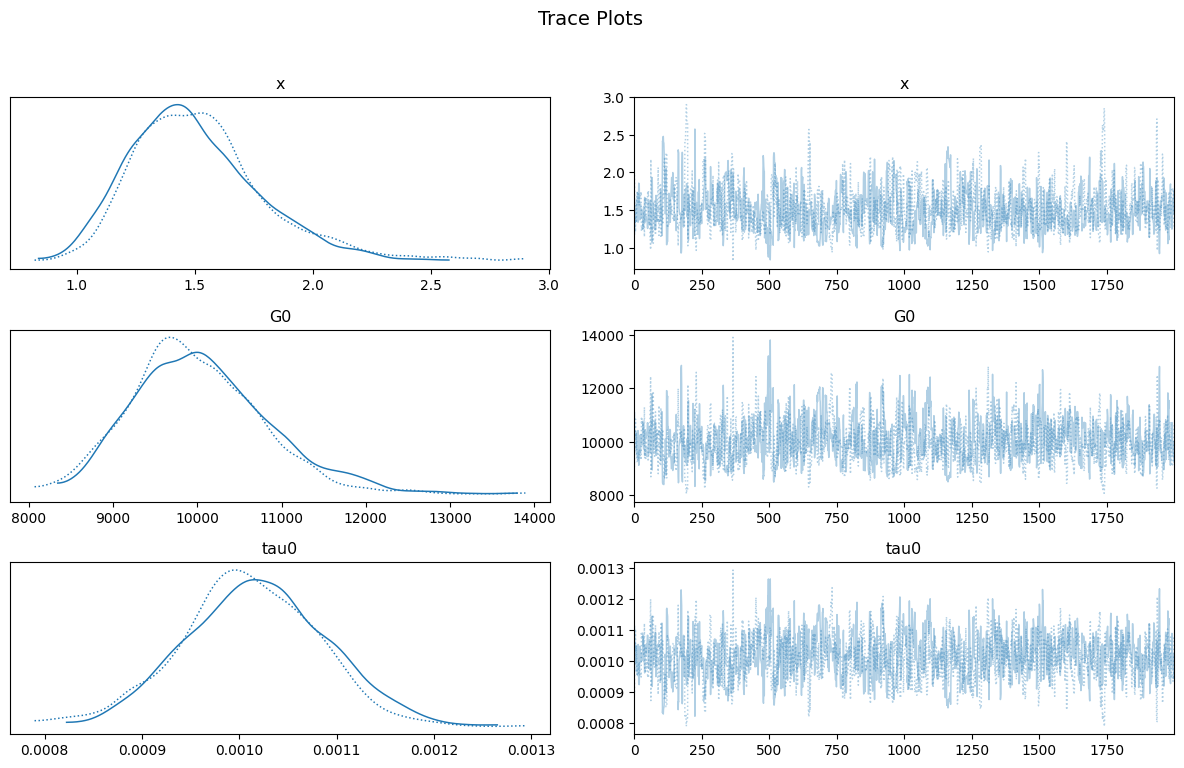

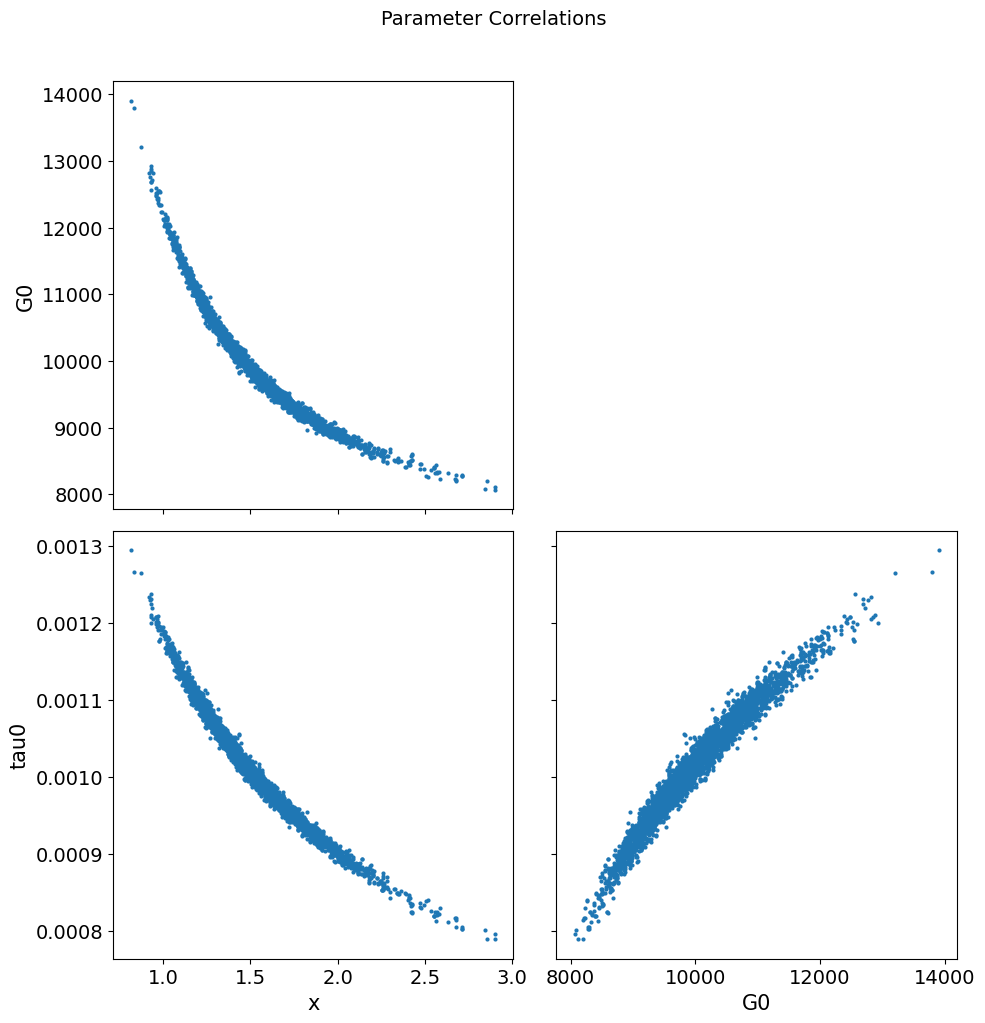

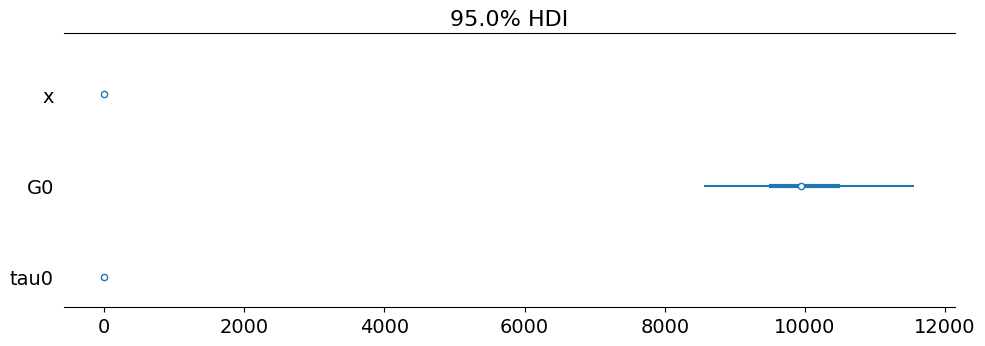

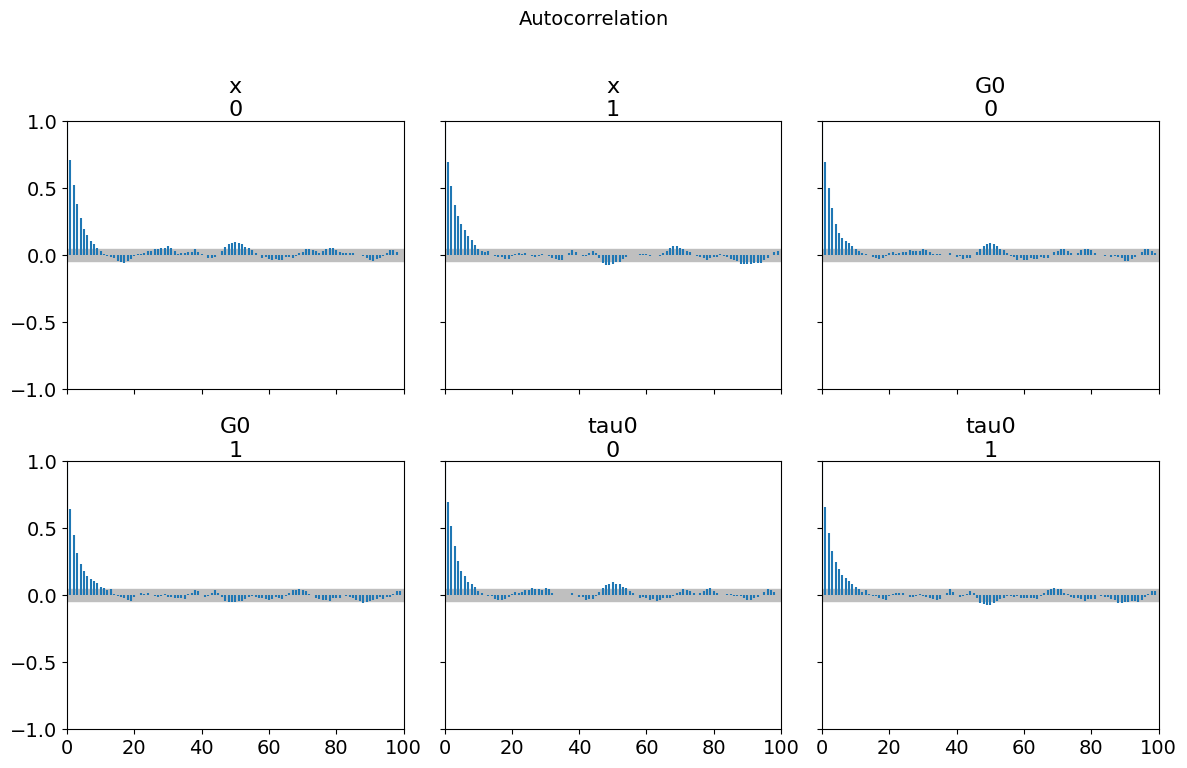

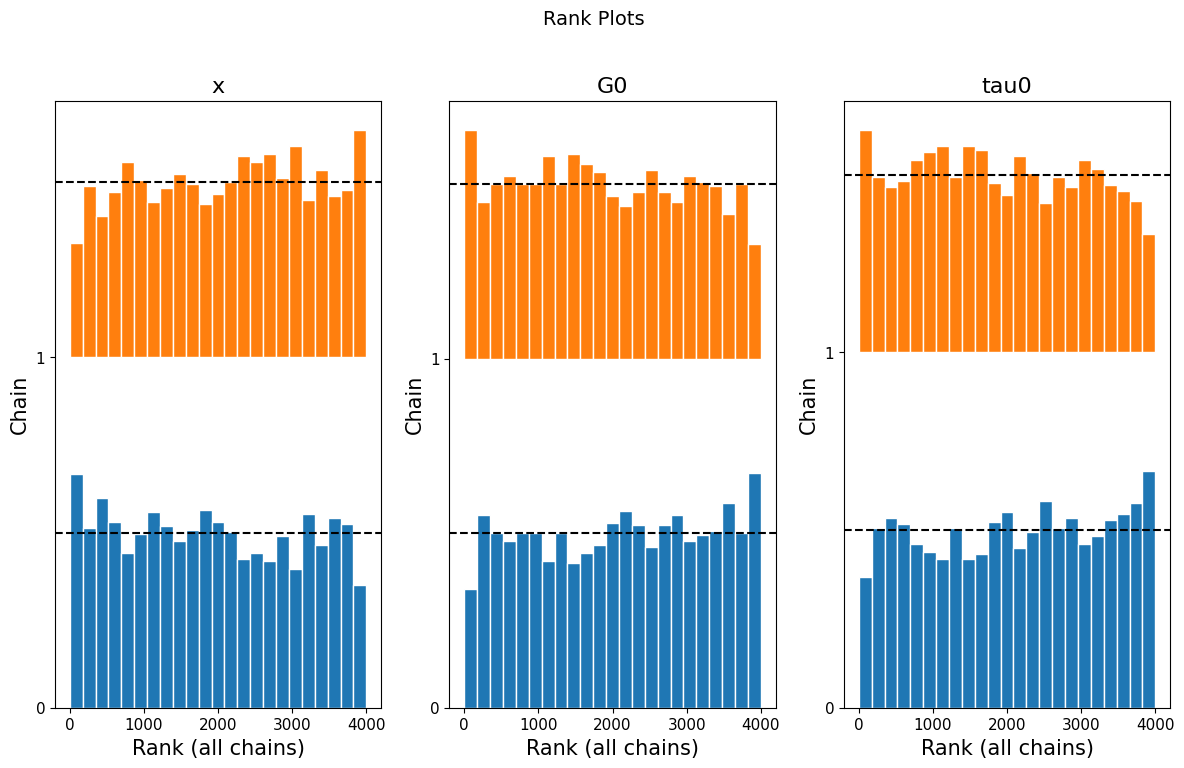

In [11]:
# ArviZ diagnostic plots (trace, pair, forest, energy, autocorr, rank)
display_arviz_diagnostics(result_bayes, ['x', 'G0', 'tau0'], fast_mode=FAST_MODE)

## 8. Material Classification Based on Noise Temperature

Demonstrate how to classify materials based on fitted x value.

Material Classification from Fitted x:
Noise temperature x = 1.412

Category: Power-law fluid (balanced)
Properties: Strong power-law, balanced solid-liquid
Examples: Soft pastes, creams, emulsions


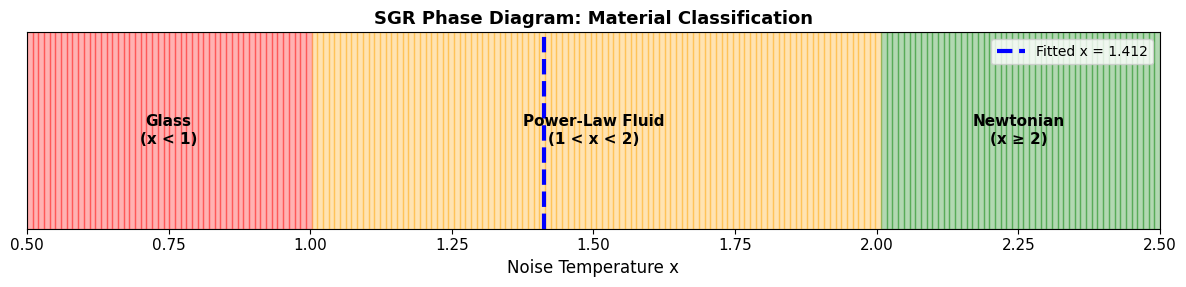

In [12]:
def classify_sgr_material(x_value):
    """Classify soft glassy material based on noise temperature."""
    if x_value < 0.8:
        category = "Strong glass"
        properties = "Yield stress, aging, non-ergodic, solid-like"
        examples = "Concentrated foams, jammed emulsions"
    elif 0.8 <= x_value < 1.0:
        category = "Weak glass (near transition)"
        properties = "Weak yield stress, slow aging, close to jamming"
        examples = "Dense colloidal suspensions"
    elif 1.0 <= x_value < 1.3:
        category = "Soft glass (low x power-law)"
        properties = "Weak power-law, slow relaxation, gel-like"
        examples = "Soft gels, weak pastes"
    elif 1.3 <= x_value < 1.7:
        category = "Power-law fluid (balanced)"
        properties = "Strong power-law, balanced solid-liquid"
        examples = "Soft pastes, creams, emulsions"
    elif 1.7 <= x_value < 2.0:
        category = "Power-law fluid (high x)"
        properties = "Approaching Newtonian, fast relaxation"
        examples = "Dilute pastes, weak emulsions"
    else:
        category = "Newtonian-like"
        properties = "Constant viscosity, liquid-like"
        examples = "Dilute suspensions, polymer solutions"
    
    return category, properties, examples

# Classify fitted material
category, properties, examples = classify_sgr_material(x_fit)

print("Material Classification from Fitted x:")
print("="*70)
print(f"Noise temperature x = {x_fit:.3f}")
print(f"\nCategory: {category}")
print(f"Properties: {properties}")
print(f"Examples: {examples}")
print("="*70)

# Create classification guide
x_range = np.linspace(0.5, 2.5, 200)
colors = []
for x_val in x_range:
    if x_val < 1.0:
        colors.append('red')  # Glass
    elif x_val < 2.0:
        colors.append('orange')  # Power-law
    else:
        colors.append('green')  # Newtonian

fig, ax = plt.subplots(figsize=(12, 3))
for i in range(len(x_range)-1):
    ax.axvspan(x_range[i], x_range[i+1], color=colors[i], alpha=0.3)

# Add phase labels
ax.text(0.75, 0.5, 'Glass\n(x < 1)', ha='center', va='center', fontsize=11, fontweight='bold')
ax.text(1.5, 0.5, 'Power-Law Fluid\n(1 < x < 2)', ha='center', va='center', fontsize=11, fontweight='bold')
ax.text(2.25, 0.5, 'Newtonian\n(x ≥ 2)', ha='center', va='center', fontsize=11, fontweight='bold')

# Mark fitted value
ax.axvline(x_fit, color='blue', linewidth=3, linestyle='--', label=f'Fitted x = {x_fit:.3f}')

ax.set_xlim(0.5, 2.5)
ax.set_ylim(0, 1)
ax.set_xlabel('Noise Temperature x', fontsize=12)
ax.set_yticks([])
ax.set_title('SGR Phase Diagram: Material Classification', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
plt.tight_layout()
display(fig)
plt.close(fig)

## 9. Interpretation and Insights

### Physical Meaning of SGR Parameters

**Noise Temperature (x):**
- Dimensionless ratio of thermal fluctuations to trap depth energy
- Controls glass transition at x = 1
- Power-law exponent: $G' \sim G'' \sim \omega^{x-1}$ for 1 < x < 2
- Directly measurable from oscillation data slope

**Modulus Scale (G0):**
- Sets absolute magnitude of elastic response
- Related to microscopic trap depth and element density
- Typical range: 10 Pa (soft gels) to 10 kPa (dense pastes)

**Attempt Time (tau0):**
- Microscopic timescale for trap hopping attempts
- Sets characteristic frequency: $\omega_c \sim 1/\tau_0$
- Typical range: nanoseconds (molecular) to milliseconds (colloidal)

### When to Use SGR Models

**SGR is appropriate when:**
1. Material exhibits power-law rheology over wide frequency range
2. Glass transition or jamming transition is relevant
3. Material is a soft glassy system (foam, emulsion, paste, colloid)
4. Classical viscoelastic models (Maxwell, Kelvin-Voigt) fail
5. Aging, yielding, or structural evolution is important

**Use alternative models when:**
1. Material shows narrow relaxation spectrum → Generalized Maxwell Model
2. Fractional power-law without jamming → Fractional models (SpringPot, FMG)
3. Exponential relaxation → Classical models (Maxwell, Kelvin-Voigt)
4. Polymers with entanglement → Tube models, Rolie-Poly

### SGRConventional vs SGRGeneric: When to Use Each

**Use SGRConventional when:**
- Standard rheological characterization (oscillation, relaxation, creep)
- Speed is important (simpler formulation)
- Fitting experimental data for material classification
- LAOS or steady shear analysis required

**Use SGRGeneric when:**
- Thermodynamic consistency is critical
- Studying nonequilibrium transitions
- Need entropy production tracking
- Coupling to other thermodynamic frameworks
- Theoretical analysis of dissipation

## Key Takeaways

1. **SGR Framework:** Statistical mechanics model for soft glassy materials based on trap model with exponential density of states

2. **Noise Temperature x:** Controls material phase transition:
   - x < 1: Glass (yield stress, solid-like)
   - 1 < x < 2: Power-law fluid (viscoelastic)
   - x ≥ 2: Newtonian (liquid-like)

3. **Three Parameters:** x (phase), G0 (magnitude), tau0 (timescale) fully characterize SGR response

4. **Two Implementations:**
   - SGRConventional: Fast, versatile (oscillation, relaxation, creep, LAOS)
   - SGRGeneric: Thermodynamically consistent, entropy production tracking

5. **Bayesian Inference:** Provides uncertainty quantification for SGR parameters, critical for noise temperature classification

6. **Material Classification:** Fitted x value directly determines material category and properties

7. **Applications:** Foams, emulsions, pastes, colloidal suspensions, and any soft glassy material with power-law rheology

## Next Steps

- Explore SRFS transform (`examples/transforms/srfs-strain-rate-superposition.ipynb`) for strain-rate frequency superposition with SGR
- Try fractional models (`examples/advanced/04-fractional-models-deep-dive.ipynb`) for comparison with power-law relaxation
- Study Generalized Maxwell Model (`examples/advanced/08-generalized_maxwell_fitting.ipynb`) for multi-mode exponential relaxation
- Apply to real experimental data from TRIOS, Anton Paar, or other rheometers

## References

1. P. Sollich, *Rheological constitutive equation for a model of soft glassy materials*, Physical Review E, 1998, 58(1), 738-759
2. P. Sollich et al., *Rheology of Soft Glassy Materials*, Physical Review Letters, 1997, 78(10), 2020-2023
3. I. Fuereder and P. Ilg, *GENERIC framework for the Fokker-Planck equation*, Physical Review E, 2013, 88, 042134
4. S.M. Fielding et al., *Aging and rheology in soft materials*, Journal of Rheology, 2000, 44(2), 323-369

### Convergence Diagnostic Interpretation

| Metric | Target | Meaning |
|--------|--------|---------|
| **R-hat < 1.01** | Chains converged | Multiple chains agree on posterior |
| **ESS > 400** | Sufficient samples | Independent information content |
| **Divergences < 1%** | Well-behaved sampler | No numerical issues in posterior geometry |

## Session Information

In [13]:
import sys

import rheojax

print("Session Information:")
print(f"  Python version: {sys.version}")
print(f"  RheoJAX version: {rheojax.__version__}")
print(f"  JAX backend: {jax.default_backend()}")
print(f"  JAX devices: {jax.devices()}")
print(f"  NumPy version: {np.__version__}")

Session Information:
  Python version: 3.13.9 (main, Oct 14 2025, 21:10:40) [Clang 20.1.4 ]
  RheoJAX version: 0.6.0
  JAX backend: cpu
  JAX devices: [CpuDevice(id=0)]
  NumPy version: 2.3.5


## Further Reading

### Handbook Documentation

- **[SGR Models Overview](../../docs/source/models/sgr/index.rst)**: Complete catalog of SGRConventional and SGRGeneric with phase diagrams
- **[SRFS Transform](../../docs/source/transforms/srfs.rst)**: Strain-Rate Frequency Superposition for flow curve collapse
- **[Shear Banding Detection](../../docs/source/models/sgr/shear_banding.rst)**: Algorithms for heterogeneous flow identification
- **[SGR Phase Diagram](../../docs/source/models/sgr/phase_diagram.rst)**: Physical interpretation of noise temperature x regimes

### Scientific Literature

- **Sollich, P. (1998)**: *Phys. Rev. E* 58:738-759. "Rheological constitutive equation for a model of soft glassy materials" (foundational SGR paper)
- **Sollich, P., et al. (1997)**: *Phys. Rev. Lett.* 78:2020-2023. Rheology of soft glassy materials (original SGR model)
- **Füreder, I., Ilg, P. (2013)**: *Phys. Rev. E* 88:042307. "GENERIC framework for SGR" (thermodynamically consistent formulation)
- **Fielding, S.M., et al. (2000)**: *J. Rheol.* 44:323-369. Aging and rheology in soft materials

### Related RheoJAX Examples

- **[../models/sgr/01-phase-transitions.ipynb](../models/sgr/01-phase-transitions.ipynb)**: Exploring glass-fluid-liquid transitions via x parameter
- **[../transforms/04-srfs.ipynb](../transforms/04-srfs.ipynb)**: SRFS analysis for flow curve superposition
- **[../models/sgr/02-aging-dynamics.ipynb](../models/sgr/02-aging-dynamics.ipynb)**: Time-dependent G(t, t_w) with waiting time effects

### Key References

1. **Sollich, P.** (1998). "Rheological constitutive equation for a model of soft glassy materials." *Physical Review E*, 58(1), 738-759.
2. **Sollich, P., et al.** (1997). "Rheology of soft glassy materials." *Physical Review Letters*, 78(10), 2020-2023.
3. **Fielding, S. M., et al.** (2000). "Aging and rheology in soft materials." *Journal of Rheology*, 44(2), 323-369.
4. **Fuereder, I. & Ilg, P.** (2013). "GENERIC framework for SGR models." *Physical Review E*, 88(4), 042134.